In [1]:
#from multiprocessing import set_start_method
#set_start_method("spawn")

import os
os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2"

In [2]:
from fastai2.basics import *
from fastai2.callback.all import *
from fastai2.data.all import *
from fastai2.data.core import *
from fastai2.distributed import *
from fastai2.data.transforms import *
from fastai2.vision.all import *
import gc
from itertools import product
from scipy import signal
import seaborn as sns
import zlib 


In [3]:
warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 500)

from pylab import rcParams
rcParams['figure.figsize'] = 20, 5
rcParams['figure.dpi'] = 300
rcParams['agg.path.chunksize'] = 10000

In [4]:
SEGMENT_SIZE      = 500_000 
TEST_SEGMENT_SIZE = 100_000

WINDOW_SIZE = 1_000
BIAS_RANGE = 0.1
CONV_KERNEL = 5
CONV_DEPTH  = 7
FILTERS = 256
HIST_BINS = 8192
K_RANGE=(0.985,1.015)
STD_RANGE=(1,1)
PADDING = CONV_DEPTH*(CONV_KERNEL-1)//2 

BS = max(1,torch.cuda.device_count()) * 128
SPLITS = 5
XTRA_DS = False

FEAT_WINDOW = 1

assert SEGMENT_SIZE % WINDOW_SIZE == 0
assert (SEGMENT_SIZE // WINDOW_SIZE) % SPLITS == 0
SEED = 321
DATA_SUFFIX = '_clean'

p_input = Path('input')
p_cache = Path('cache')
p_csv   = Path('csv')

# Read data

In [5]:
# read data
train_dtypes = {'time': np.float32, 'signal': np.float32, 'open_channels': np.int32 }
test_dtypes  = {'time': np.float32, 'signal': np.float32 }
df_train  = pd.read_csv(p_input / f'train.csv', dtype= train_dtypes)
df_test   = pd.read_csv(p_input / f'test.csv',  dtype= test_dtypes)
df_train_drift = pd.read_csv(p_input / f'train{DATA_SUFFIX}.csv', dtype= train_dtypes)
df_test_drift  = pd.read_csv(p_input / f'test{DATA_SUFFIX}.csv',  dtype= test_dtypes)
sub   = pd.read_csv(p_input / 'sample_submission.csv',  dtype={'time': np.float32})
df_train['drift'] = df_train['signal'] - df_train_drift['signal']
df_test['drift']  = df_test['signal']  - df_test_drift['signal']

In [6]:
train_drift = np.zeros_like(df_train['drift'])
train_drift[1:] = df_train['drift'][:-1]
df_train['signal'] =df_train['signal']-train_drift

In [7]:
test_drift = np.zeros_like(df_test['drift'])
test_drift[1:] = df_test['drift'][:-1]
df_test['signal'] = df_test['signal']-test_drift

In [8]:
d_xtra_csvs = {
    1: ['outfinaltest10.csv',  'outfinaltest44.csv',],#  'outfinaltest78.csv',],  'outfinaltest10.csv',  'outfinaltest44.csv'],
    3: ['outfinaltest1.csv',   'outfinaltest2.csv',   'outfinaltest3.csv',   'outfinaltest4.csv', 'outfinaltest5.csv'],
    5: ['outfinaltest328.csv', 'outfinaltest534.csv', 'outfinaltest747.csv',]#, 'outfinaltest328.csv', 'outfinaltest534.csv']
}

df_train_xtra = None
for _,xtra_csvs in d_xtra_csvs.items():
    for xtra_csv in xtra_csvs:
        xx = pd.read_csv(p_input / xtra_csv , header=None,names=['time', 'signal', 'open_channels'])
        df_train_xtra = pd.concat((xx,df_train_xtra), axis=0)
df_train_xtra['drift']  = 0.
if XTRA_DS: df_train = pd.concat((df_train,df_train_xtra), axis=0)

In [9]:
train = torch.cat((torch.FloatTensor(df_train['signal'        ].values).unsqueeze(0),
                   #torch.FloatTensor(df_train['drift'         ].values).unsqueeze(0),
                   torch.FloatTensor(df_train['open_channels' ].values).unsqueeze(0)))
test  = torch.cat((torch.FloatTensor(df_test ['signal'        ].values).unsqueeze(0),
                   #torch.FloatTensor(df_test ['drift'         ].values).unsqueeze(0)
                  ))

In [10]:
test.shape

torch.Size([1, 2000000])

In [11]:
test[0,:3],test[0,TEST_SEGMENT_SIZE-3:TEST_SEGMENT_SIZE+3],test[0,-3:]

(tensor([-2.6498, -2.8494, -2.8601]),
 tensor([-2.6944, -2.2560, -2.4560,  0.4461,  0.6579,  1.2465]),
 tensor([-2.8285, -2.9092, -2.7422]))

In [12]:
test_clean  = np.load(str(p_input / '3_x_sin_50hz_test.npy'))
train_clean = np.load(str(p_input / '3_x_sin_50hz_train.npy'))

In [13]:
test[0] = Tensor(test_clean)
train[0] = Tensor(train_clean)

In [14]:
train = train.view(2,-1,SEGMENT_SIZE)[:,[0,1,2,3,4,5,6,8,9],...]
train_k_x =   train[0].view(-1,SEGMENT_SIZE,1)
train_k_y =   train[1].view(-1,SEGMENT_SIZE,1)
test_x    =    test.view(-1,TEST_SEGMENT_SIZE,1)

# Synth

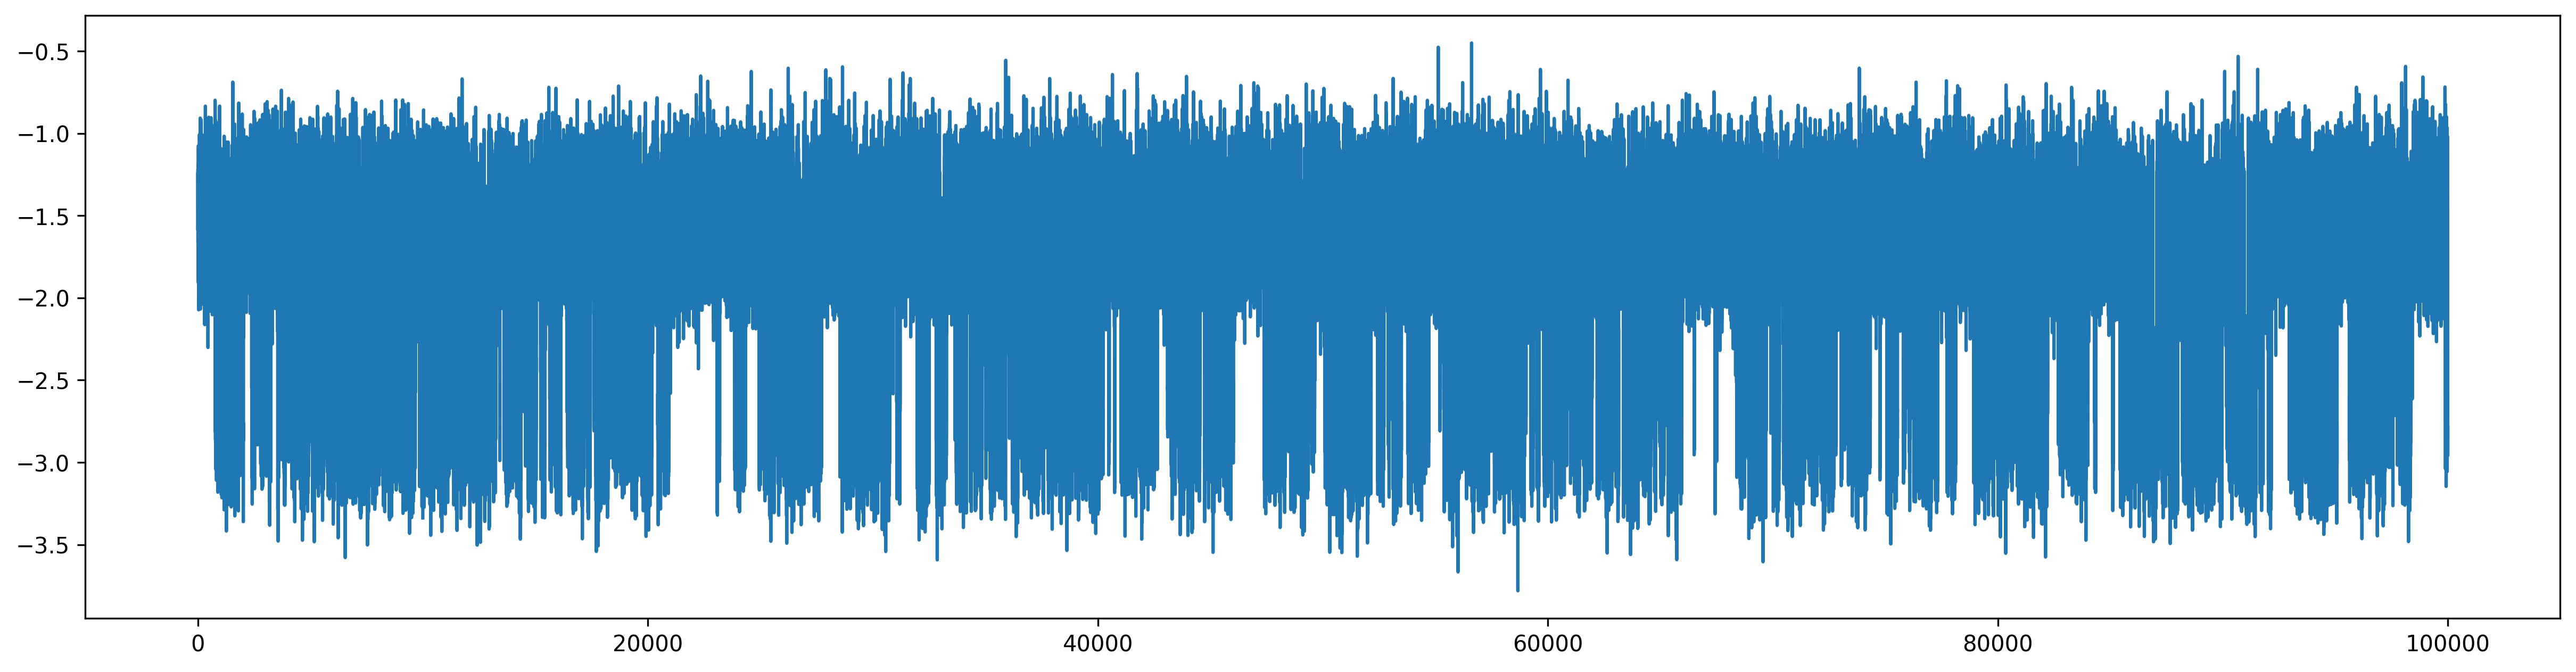

In [15]:
class RandomStack:
    def __init__(self,segments): self.segments,self.n_segments,self.stack=segments,segments.shape[0],[]
    def pop(self):
        if len(self.stack) == 0: self.stack = np.random.choice(range(self.n_segments),self.n_segments,replace=False).tolist()
        return self.segments[self.stack.pop()]
class SynthChannels:
    def __init__(self):
        p_synth = Path('synth')
        use_memmap = True
        load_fn = np.load if not use_memmap else partial(np.lib.format.open_memmap, mode='r')
        high_fname,low_fname = 'high','low2'
        try:
            self.high = load_fn(str(p_synth / f'{high_fname}.npy'))
            self.low  = load_fn(str(p_synth /  f'{low_fname}.npy'))
        except:
            self.high   = pd.read_csv(p_synth / f'{high_fname}.csv',header=None).values.astype('uint8')
            self.low    = pd.read_csv(p_synth /  f'{low_fname}.csv',header=None).values.astype('uint8')
            np.save(str(p_synth / f'{high_fname}.npy'), self.high)
            np.save(str(p_synth /  f'{low_fname}.npy'), self.low)
        self.high = self.high.reshape(-1,TEST_SEGMENT_SIZE)
        self.low  =  self.low.reshape(-1,TEST_SEGMENT_SIZE)
        self.h_segments,self.l_segments = RandomStack(self.high),RandomStack(self.low)
        self.set_seed(0)
    def set_seed(self,seed):
        self.seed = seed
        np.random.seed(self.seed)
        torch.manual_seed(self.seed)
        self.l_segments.stack = self.h_segments.stack = []
    def get_synth_segment_y(self,states,max_channels,size=SEGMENT_SIZE):
        assert size % TEST_SEGMENT_SIZE == 0
        y = torch.zeros((size,),dtype=torch.uint8)
        self.seed += {'l':1, 'h':2}[states]*0x10+max_channels+(size//TEST_SEGMENT_SIZE)*0x20 % 2**32
        torch.manual_seed(self.seed)
        np.random.seed(self.seed)
        states = {'l':self.l_segments, 'h':self.h_segments}[states]
        for i in range(max_channels):
            for ii in range(size//TEST_SEGMENT_SIZE): y[ii*TEST_SEGMENT_SIZE:(ii+1)*TEST_SEGMENT_SIZE] += states.pop()
        return y.clamp(0, 10)
    def get_synth_segment_xy(self,states,max_channels,size=TEST_SEGMENT_SIZE,add_ac=False,y=None,
                             add_noise=True,add_bias=True, std_range =(1.,1.), k_range=(1.,1.)):
        kernel = tensor([-1.6590e-03, -1.1617e-04, -1.0344e-03,  8.4467e-04, -9.7054e-04,
                  1.4413e-03,  6.5739e-03,  2.8979e-02,  1.2115e+00, -1.0717e-03,
                 -3.8138e-03,  6.0101e-04,  1.2317e-04,  3.1660e-03, -8.8741e-04,
                  3.2797e-04,  2.5820e-03, -2.3032e-03])
        test_std_by_type = {('l', 3): [0.23856227099895477,
                                       
              0.2386934608221054,
              0.23847833275794983,
              0.23833979666233063,
              0.24214892089366913,
              0.24653472006320953,
              0.2441188395023346],
             ('h', 3): [0.2698204517364502, 0.2679280936717987],
             ('h', 5): [0.27920418977737427, 0.27736446261405945],
             ('l', 4): [0.23756568133831024,
              0.24620571732521057,
              0.24222536385059357],
             ('h', 1): [0.2443782091140747],
             ('h', 10): [0.3530166447162628, 0.3537397086620331],
             ('l', 2): [0.23785734176635742,
              0.2443142682313919,
              0.24280819296836853]}
        train_std_by_type = {
            ('l', 1): [0.24515989422798157, 0.24703997373580933],
            ('h', 1): [0.24486009776592255, 0.2447292059659958],
            ('h', 3): [0.265836238861084],
            ('h', 10): [0.4045635759830475, 0.40377894043922424],
            ('h', 5): [0.28642651438713074, 0.28378984332084656]}

        dim_k = kernel.numel()
        if max_channels is None: max_channels = y.max()
        bias = tensor([-5.5336 if max_channels >= 10 else -2.7708])
        if y is None: y = self.get_synth_segment_y(states,max_channels,size)
        y_padded = torch.zeros(y.shape[0]+dim_k-1)
        cc = (dim_k-1)//2
        y_padded[cc:cc+y.shape[0]] = y.float()
        y_padded = y_padded.view(1,1,-1)
        k_range = k_range[0]+(k_range[1]-k_range[0])*torch.rand(1,).item()
        x = (F.conv1d(y_padded,k_range*kernel.view(1,1,-1)).flatten() + bias).to(y.device)
        if add_noise:
            torch.manual_seed(self.seed)
            np.random.seed(self.seed)
            if add_ac:
                ac_weight,ac_freq,ac_phase = -0.12838999,50+0.2*(torch.rand(1)-0.5),2*math.pi*torch.rand(1)
                x_range = torch.arange(x.shape[0]).float().to(x.device)
                wave = (ac_weight * torch.sin( x_range * 2*math.pi/10000 * ac_freq + ac_phase))
                x += wave
            max_channels = min(max_channels,10)
            std_by_type = train_std_by_type if (states,max_channels) in train_std_by_type else test_std_by_type
            std = np.random.choice(std_by_type[(states,max_channels)])
            std_range = std_range[0]+(std_range[1]-std_range[0])*torch.rand(1,).item()
            x += std_range * std * torch.randn(x.numel()).to(x.device)
            if add_bias: x += BIAS_RANGE*(2*torch.rand(1)-1)
        return x.unsqueeze(-1),y.unsqueeze(-1)
    
sc= SynthChannels()
plt.plot(sc.get_synth_segment_xy('h',1)[0])

In [16]:
def gen_balanced(N_BALANCED, N_REBALANCED,seed=0):
    try:
        f_balanced = str(p_cache / f"balanced_{N_BALANCED}_{N_REBALANCED}_{seed}.pkl")
        balanced_types = pickle.load(open(f_balanced,"rb"))
    except:
        possible_types = [('l', 1), ('l', 3), ('l', 4), ('h', 1), ('h', 3), ('h',5), ('h',10), 
                          ('h',11), ('h',12), ('h',13), ('h',14)]
        p_dist = np.zeros((len(possible_types),11))
        sc.set_seed(seed)
        for _ in range(100):
            for i,m_type in enumerate(possible_types):
                p_dist[i] += np.bincount(sc.get_synth_segment_y(*m_type,SEGMENT_SIZE),minlength=11)/(SEGMENT_SIZE)
        p_dist /= 100

        balanced_types = []
        p = np.zeros_like(p_dist[0])
        def add_type(t,p):
            balanced_types.append(possible_types[t])
            p += p_dist[t]

        np.random.seed(seed)
        for i in range(N_BALANCED):
            cands = np.where(p.min()==p)[0]
            min_class = np.random.choice(cands)
            best_chance = np.random.choice(p_dist[:,min_class].argsort()[::-1][:4])
            add_type(best_chance,p)
        for _ in range(N_REBALANCED): add_type(np.random.randint(3),p)
        with open(f_balanced, "wb") as out: pickle.dump(balanced_types, out)
        print(p)
    return balanced_types

In [17]:
std_corr = 1 #0.9965
std_correction = (std_corr,std_corr)

In [18]:
def gen_cached(train_types,lazy=False):
    try:
        segment_size = TEST_SEGMENT_SIZE
        ltt = zlib.crc32(bytes(train_types.__repr__(), 'utf8'))
        train_s_fname = str(p_cache / f"train_s_{ltt}")
        if lazy: return train_types, train_types, train_s_fname
        train_s_x = torch.load(f'{train_s_fname}_x')
        train_s_y = torch.load(f'{train_s_fname}_y')
        assert train_s_x.shape==(len(train_types),segment_size,1)
        assert train_s_y.shape==(len(train_types),segment_size,1)
    except:
        train_s_x = np.nan * torch.empty(len(train_types),segment_size,1)
        train_s_y =          torch.empty(len(train_types),segment_size,1,dtype=torch.uint8)
        sc.set_seed(3)
        for i,segment in progress_bar(enumerate(train_types),total=len(train_types)):
            train_s_x[i],train_s_y[i] = sc.get_synth_segment_xy(*segment,segment_size,k_range=K_RANGE)
        torch.save(train_s_x,f"{train_s_fname}_x")
        torch.save(train_s_y,f"{train_s_fname}_y")
    return train_s_x,train_s_y,train_s_fname


In [19]:
models = [
    'conv_swift_L1_2304267_5_5_256_128_t6250000_v12000_BS768_WS1000_pucv0.944067_prcv0.944030_trkcv0.943749_trkscv0.943234_clean_synth_clean50hz_properlb',
    'conv_swift_L1_2632203_5_6_256_128_t6250000_v12000_BS768_WS1000_pucv0.943868_prcv0.943683_trkcv0.943796_trkscv0.943167_clean_synth_clean50hz_properlb',
    'conv_swift_L1_2960139_5_7_256_128_t6250000_v12000_BS768_WS1000_pucv0.944133_prcv0.944059_trkcv0.943782_trkscv0.943254_clean_synth_clean50hz_properlb',
    'conv_swift_L1_2370059_3_8_256_128_t6250000_v12000_BS768_WS1000_pucv0.943905_prcv0.943857_trkcv0.943534_trkscv0.943054_clean_synth_clean50hz_properlb'
]

models = []

In [20]:
#test_types = [('l', 3), ('h', 3), ('h', 5), ('l', 4), ('h', 1), ('h', 10), ('h', 5), ('h', 10), ('l', 3), ('h', 3),
#              ('l', 3), ('l', 3), ('l', 2), ('l', 4), ('l', 4), ('l',  3), ('l', 3), ('l',  2), ('l', 2), ('l', 3)]
test_types = [('l', 3), ('h', 3), ('h', 5), ('l', 3), ('h', 1), ('h', 10), ('h', 5), ('h', 10), ('l', 3), ('h', 3),
              ('l', 3), ('l', 3), ('l', 3), ('l', 3), ('l', 3), ('l',  3), ('l', 3), ('l',  3), ('l', 3), ('l', 3)]


In [21]:
IS_L1 = len(models) == 0

N_BALANCED   = 100_000//4
N_REBALANCED = N_BALANCED//4

train_l2_types = gen_balanced(N_BALANCED//16,N_REBALANCED//16,123)

train_types = gen_balanced(N_BALANCED,N_REBALANCED, 
                           WINDOW_SIZE+int(BIAS_RANGE*100)+
                           CONV_KERNEL+CONV_DEPTH+FILTERS+HIST_BINS) if IS_L1 else train_l2_types

train_s_x,train_s_y,train_s_fname = gen_cached(train_types,True)

if not IS_L1:
    for m in models:
        pp = torch.load(f"{train_s_fname}_k_{m}")
        train_k_x = torch.cat((train_k_x,pp),dim=-1)
        pp = torch.load(f"{train_s_fname}_test_{m}")
        test_x = torch.cat((test_x,pp),dim=-1)
    #train_s_x = train_k_x
    #train_s_y = train_k_y


[9744.23055006 2113.38425212 1587.09083972 2283.45886302 2012.10526222
 1565.60302516 1566.52658412 2601.7937545  3093.9204699  2580.6205757
 2101.26582348]


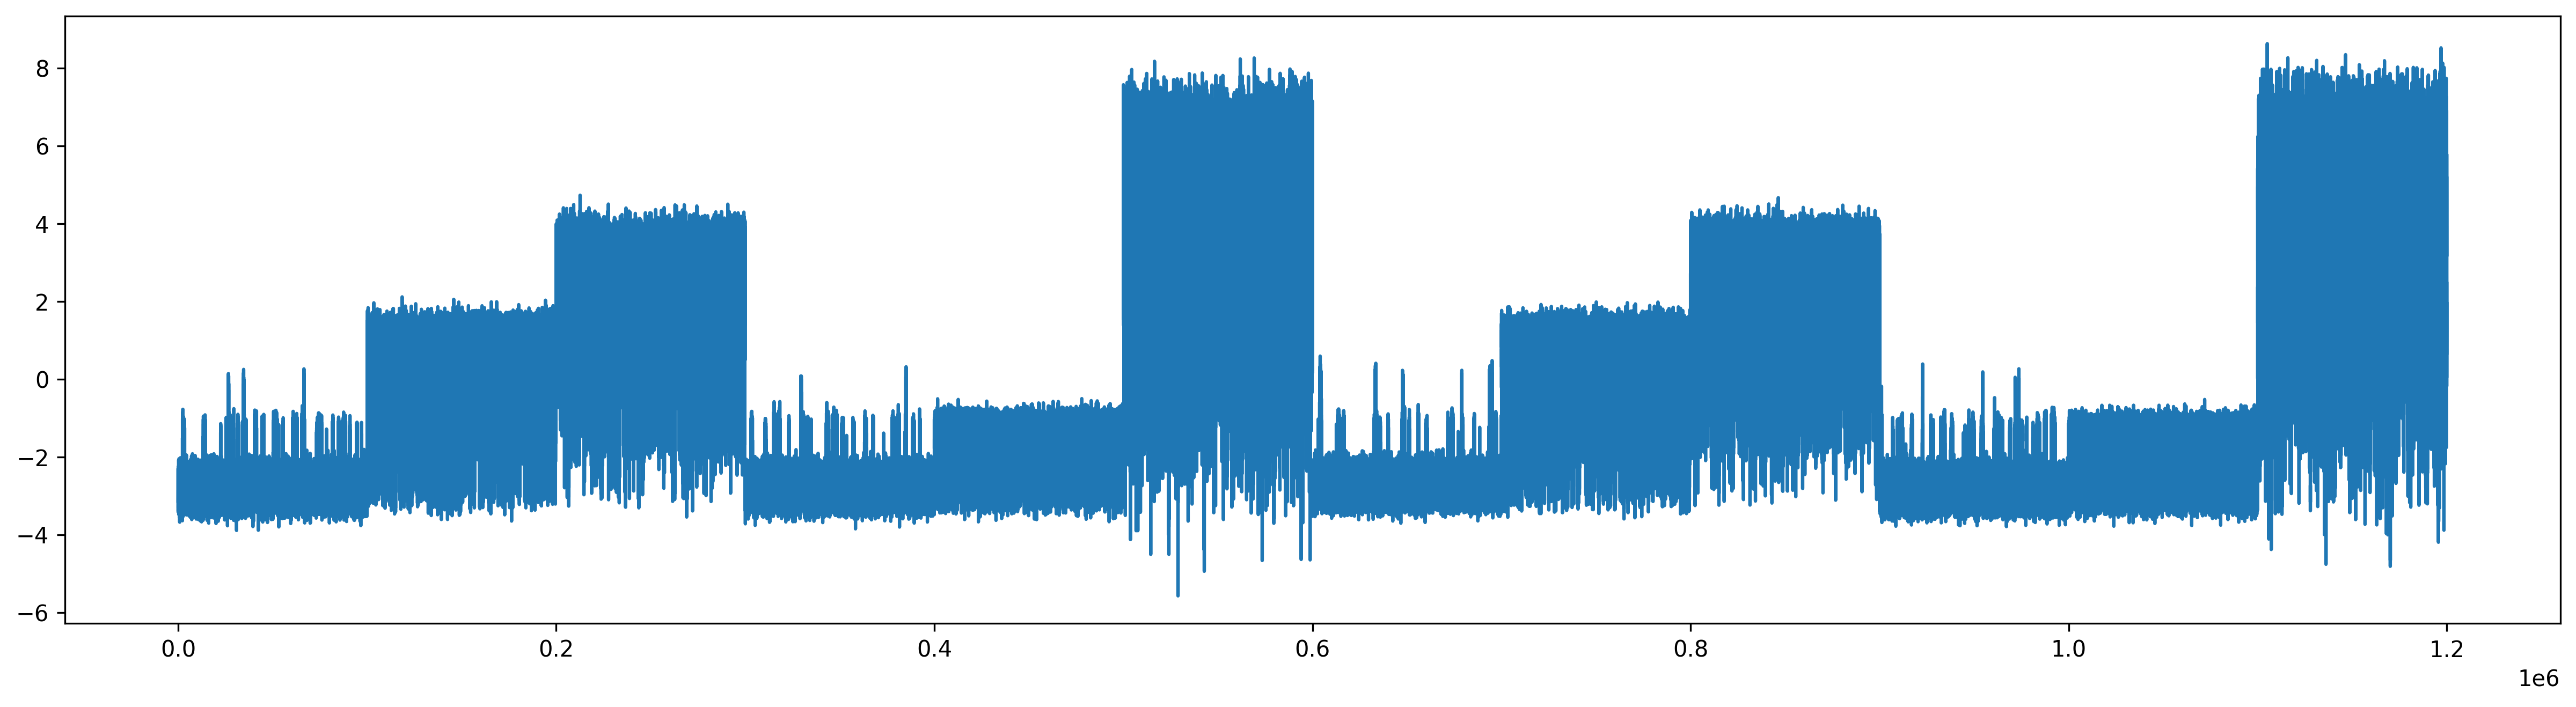

In [22]:
flatten = lambda l: [item for sublist in l for item in sublist]

public_types  = test_types[:6]*20
private_types = test_types[6:]*9

public_s_x = np.nan * torch.empty(len(public_types),TEST_SEGMENT_SIZE,1)
public_s_y =          torch.empty(len(public_types),TEST_SEGMENT_SIZE,1,dtype=torch.uint8)
sc.set_seed(1)
for i,segment in enumerate(public_types): 
    public_s_x[i],public_s_y[i]= sc.get_synth_segment_xy(*segment,TEST_SEGMENT_SIZE, std_range=std_correction)
plt.plot(public_s_x[:6*2].flatten())

In [23]:
for m in models:
    pp = torch.load(f"{train_s_fname}_public_s_{m}")
    public_s_x = torch.cat((public_s_x,pp),dim=-1)

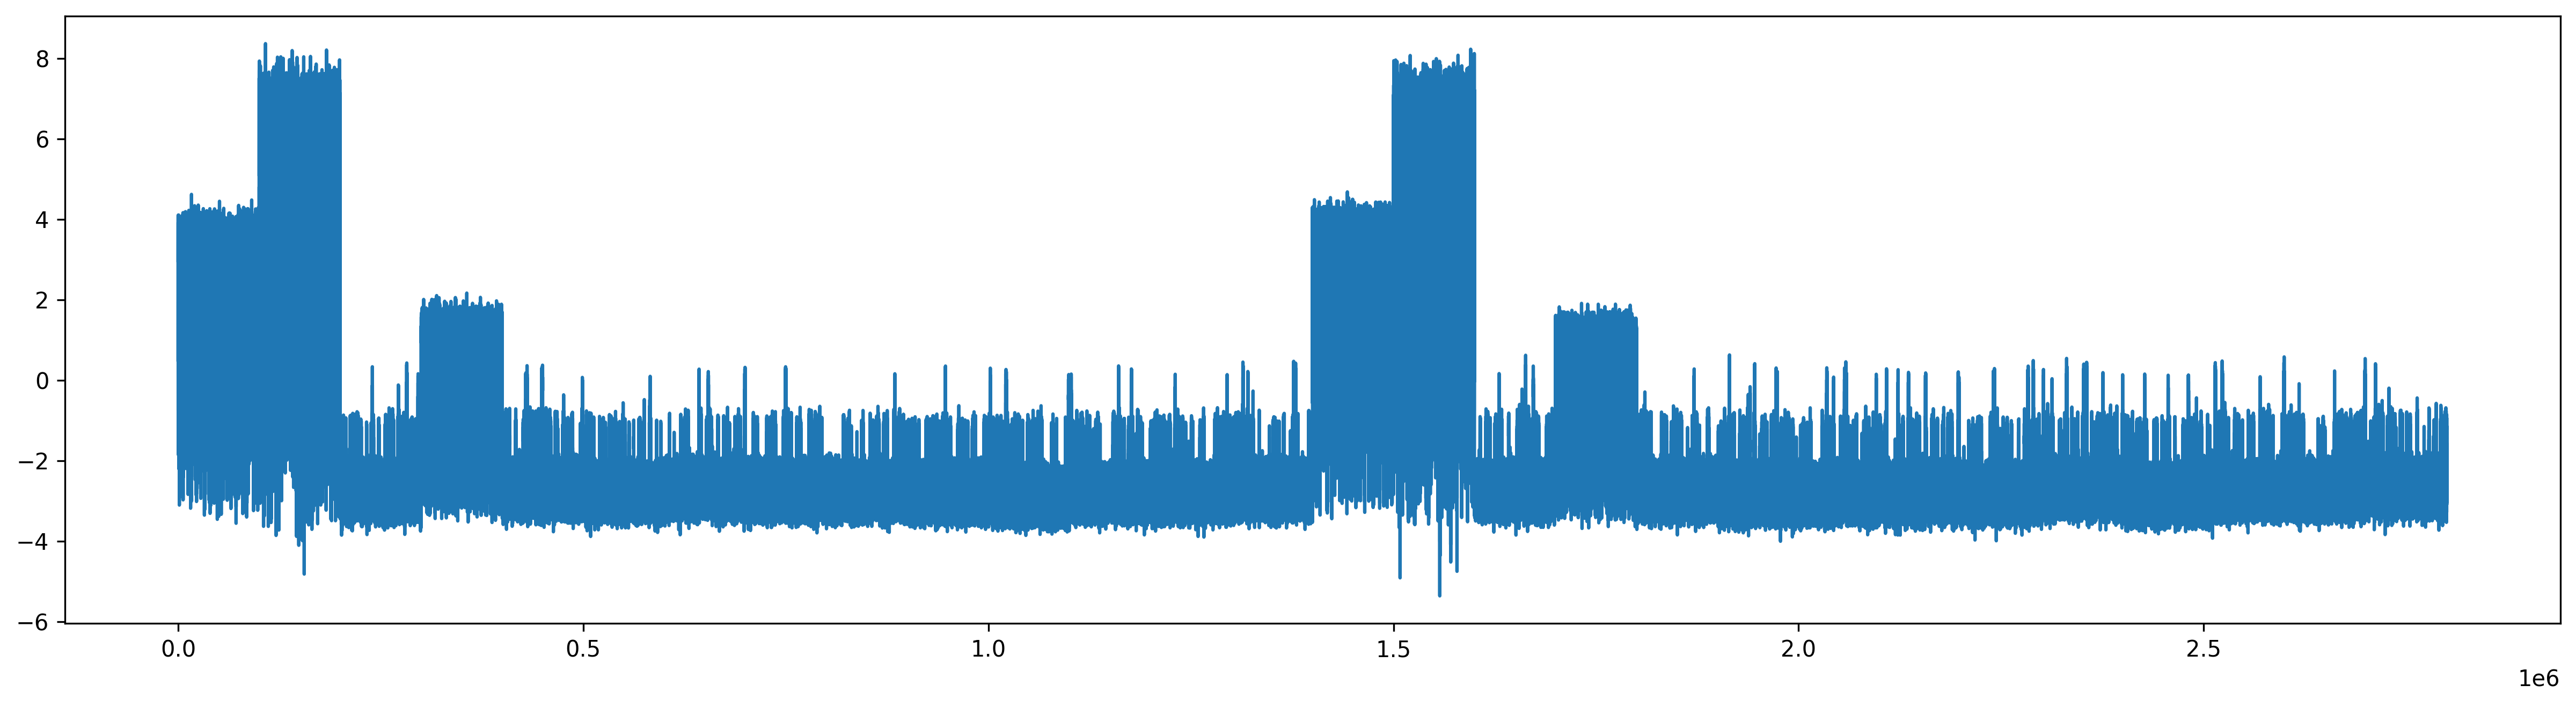

In [24]:
private_s_x = np.nan * torch.empty(len(private_types),TEST_SEGMENT_SIZE,1)
private_s_y =          torch.empty(len(private_types),TEST_SEGMENT_SIZE,1,dtype=torch.uint8)
sc.set_seed(2)
for i,segment in enumerate(private_types): 
    private_s_x[i],private_s_y[i]= sc.get_synth_segment_xy(*segment,TEST_SEGMENT_SIZE, std_range=std_correction)
plt.plot(private_s_x[:14*2].flatten())

In [25]:
for m in models:
    pp = torch.load(f"{train_s_fname}_private_s_{m}")
    private_s_x = torch.cat((private_s_x,pp),dim=-1)

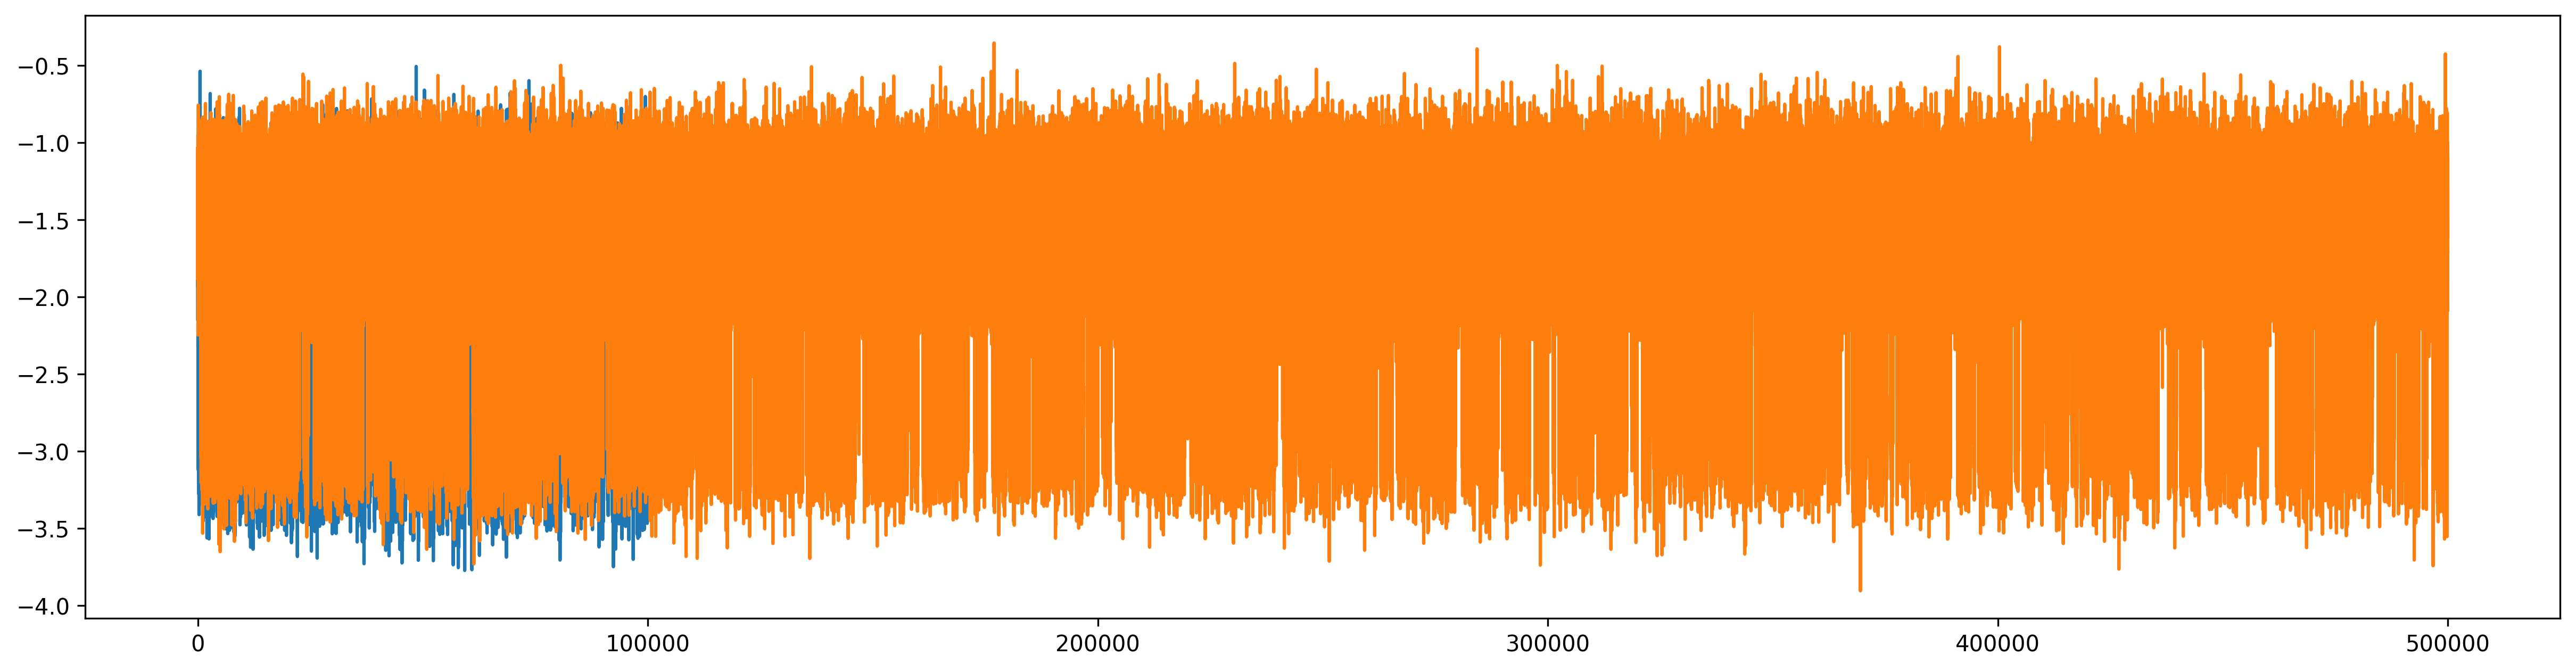

In [26]:
train_ks_types = [('l', 1), ('l', 1), ('h', 1), ('h', 3), ('h', 10), ('h', 5), ('h', 1), ('h', 5), ('h', 10)] * 5
train_ks_x = np.nan * torch.empty(len(train_ks_types),TEST_SEGMENT_SIZE,1)
train_ks_y =          torch.empty(len(train_ks_types),TEST_SEGMENT_SIZE,1,dtype=torch.uint8)
sc.set_seed(7)
for i,segment in enumerate(train_ks_types): train_ks_x[i],train_ks_y[i]=\
    sc.get_synth_segment_xy(*segment,TEST_SEGMENT_SIZE, std_range=std_correction)
plt.plot(train_ks_x[2].flatten())
plt.plot(train_k_x [2].flatten())

In [27]:
for m in models:
    pp = torch.load(f"{train_s_fname}_ks_{m}")
    train_ks_x = torch.cat((train_ks_x,pp),dim=-1)

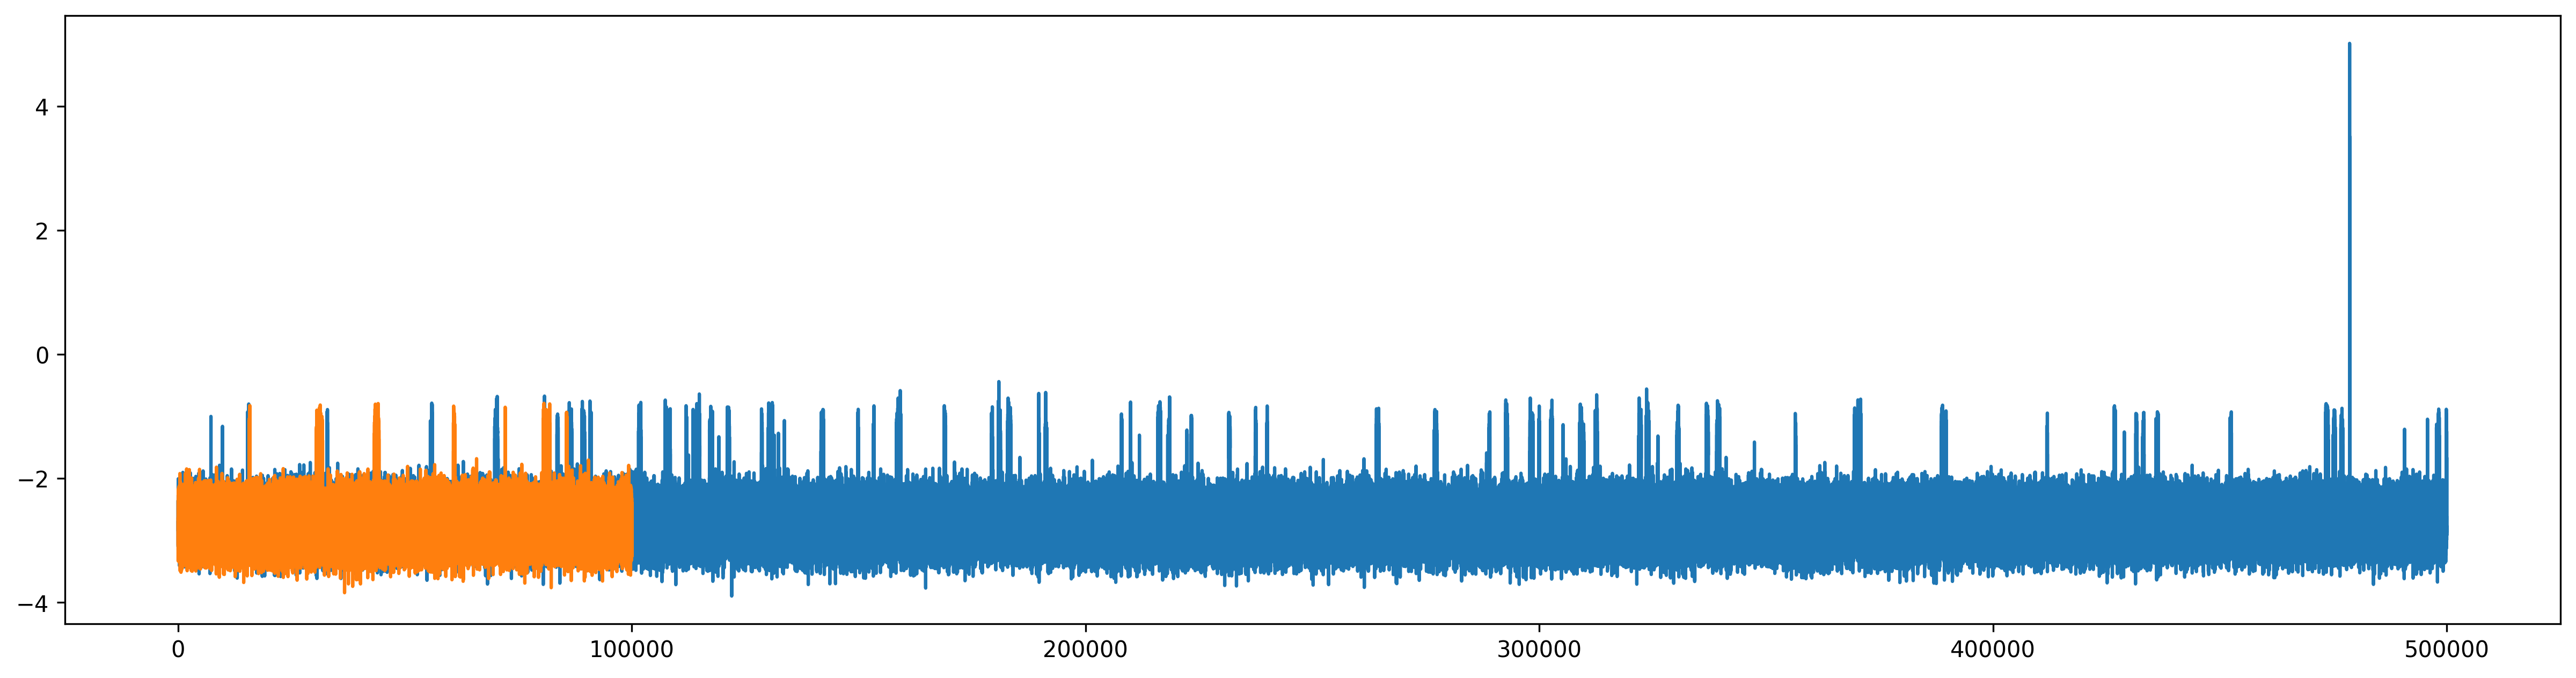

In [28]:
plt.plot(train_k_x[0,...,0])
plt.plot(train_ks_x[0,...,0])

# Normalize

In [29]:
train_k_x.mean(dim=(0,1)).shape

torch.Size([1])

In [30]:
signal_mean, signal_std = train_k_x.mean(dim=(0,1)),train_k_x.std(dim=(0,1))
signal_min = min(train_k_x[...,0].min(), test_x[...,0].min())-BIAS_RANGE
signal_max = max(train_k_x[...,0].max(), test_x[...,0].max())+BIAS_RANGE+(1.21*0.015*11)
signal_mean, signal_std, signal_min, signal_max

(tensor([0.1038]), tensor([2.5917]), tensor(-5.8129), tensor(8.8765))

# Dataset and splits

In [31]:
len(train_s_x)

31250

In [32]:
class IonDataset(torch.utils.data.Dataset):
    def calc_hist(self):
        self.histc = {}
        self.histn = {}
        for s in range(self.x.shape[0]):
            x = self.x[s,...,0].cuda()
            x_min,x_max = x.min(), x.max()
            histc = torch.histc(x,bins=HIST_BINS,min=signal_min,max=signal_max)
            histc /= histc.max()
            self.histc[s] = histc.cpu()
            histn = torch.histc(x,bins=HIST_BINS,min=x_min,max=x_min)
            histn /= histn.max()
            self.histn[s] = histn.cpu()
            del x
        
    def __init__(self,x,y=None,idx=None,jitter=False,shift=0,mult=1):
        super().__init__()
        
        #if y is not None: assert x.shape[0]*x.shape[1] == y.shape[0]*y.shape[1]
        self.x,self.y,self.jitter,self.shift= x,y,jitter,shift
        if isinstance(self.x, list):
            self.n_segments,self.segment_size = len(self.x),TEST_SEGMENT_SIZE
        else:
            self.n_segments,self.segment_size = x.shape[0],x.shape[1]
        self.idx = ifnone(idx,list(product(range(self.n_segments),np.arange(self.segment_size//WINDOW_SIZE)))) * mult
        self.n_inp = 1
        self.idx_set = set(self.idx)
        #self.calc_hist()
        
    def __len__(self): return len(self.idx)
    
    def __getitem__(self, idx):
        s,o=self.idx[idx]
        jitter = 0
        if self.jitter:
            os,oe = 0,0
            if ((s,(o-1)) in self.idx_set): os = -WINDOW_SIZE//2
            if ((s,(o+1)) in self.idx_set): oe =  WINDOW_SIZE//2
            jitter = torch.randint(os,oe,(1,)).item()
        so,se = self.shift+jitter+o*WINDOW_SIZE,self.shift+jitter+(o+1)*WINDOW_SIZE
        ss_x = (torch.arange(so-PADDING,se+PADDING) % self.segment_size)
        ss_y = (torch.arange(so        ,se        ) % self.segment_size)
        if isinstance(self.x,list):
            x_data,y_data = sc.get_synth_segment_xy(*self.x[s],size=TEST_SEGMENT_SIZE,
                                                    k_range=K_RANGE,std_range=STD_RANGE)
            x_data,y_data = x_data.unsqueeze(0),y_data.unsqueeze(0)
            s = 0
        else:
            x_data,y_data = self.x,self.y
        x =  (x_data[s,ss_x,:], x_data[s,:,:])
        if self.y is not None: y_open_channels = y_data[s:s+1,ss_y,0].long()
        return (x,y_open_channels) if self.y is not None else (x,)

In [33]:
if IS_L1: train_s_ds   = IonDataset(train_s_x,   train_s_y, jitter=False)

In [34]:
public_s_ds  = IonDataset(public_s_x,  public_s_y)
private_s_ds = IonDataset(private_s_x, private_s_y)
train_k_ds   = IonDataset(train_k_x,   train_k_y, mult = 1 if IS_L1 else 500)
train_ks_ds  = IonDataset(train_ks_x,  train_ks_y)
test_ds      = IonDataset(test_x)

In [35]:
class Normalize(Transform):
    parameters,order=L('mean', 'std'),99
    def __init__(self,mean,std): self.mean,self.std =mean,std
    def encodes(self,xy):
        return [((t[0]-self.mean.to(t[0].device)) / self.std.to(t[0].device),t[1]) if i==0 else t 
                for i,t in enumerate(xy)]

def make_dl(ds,bs=BS,shuffle=False,after_batch=Normalize(signal_mean,signal_std)):
           return DataLoader(ds, bs, shuffle=shuffle, num_workers=32, pin_memory=True, after_batch= after_batch)
            
if IS_L1: train_s_dl   = make_dl(train_s_ds,shuffle=True)
public_s_dl  = make_dl(public_s_ds)
private_s_dl = make_dl(private_s_ds)
train_k_dl   = make_dl(train_k_ds,shuffle=not IS_L1)
train_ks_dl  = make_dl(train_ks_ds)
test_dl      = make_dl(test_ds,bs=BS//2)

dls = DataLoaders(train_s_dl if IS_L1 else train_k_dl, public_s_dl, test_dl, device=default_device())

# Model 

In [36]:
class MergeLayerC(Module):
    def forward(self, x): 
        res = (x+x.orig[...,(CONV_KERNEL-1)//2:-(CONV_KERNEL-1)//2])
        return res

def make_block(fin,fout):
    return SequentialEx(
        nn.Conv1d(fin, fout,1, bias=False),nn.BatchNorm1d(fout),Swish(),
        nn.Conv1d(fout,fout,CONV_KERNEL, bias=False),nn.BatchNorm1d(fout),Swish(),
        nn.Conv1d(fout,fout,1, bias=False),nn.BatchNorm1d(fout),
        MergeLayerC(),
        Swish(),
    )

'''
def make_block(fin,fout):
    return SequentialEx(
        nn.Conv1d(fin,fout,CONV_KERNEL),Swish(),
    )
'''

class Classifier(nn.Module):
    def __init__(self,fin=11*len(models) + 1):
        super().__init__()
        f = FILTERS

        self.conv = nn.Sequential(*flatten(
            [(nn.Conv1d(f if i!=0 else fin,f,CONV_KERNEL, bias=True),
              Swish()) for i in range(CONV_DEPTH)]))
        
        assert HIST_BINS//64 >= f//2
        self.hist = nn.Sequential(
            nn.Linear(HIST_BINS     ,HIST_BINS//16), Swish(),
            nn.Linear(HIST_BINS//16 ,HIST_BINS//32), Swish(),
            nn.Linear(HIST_BINS//32 ,HIST_BINS//64), Swish(),            
            nn.Linear(HIST_BINS//64 , f), Swish(),            
        ) 
        
        self.hist_conv = nn.Sequential(
            nn.Conv1d( 2,   f//8 ,7,stride=2), Swish(),
            nn.Conv1d(f//8, f//4 ,7,stride=2), Swish(), 
            nn.Conv1d(f//4, f//4 ,7,stride=2), Swish(), 
            nn.Conv1d(f//4, f//4 ,7,stride=2), Swish(), 
            nn.Conv1d(f//4, f//2 ,7,stride=2), Swish(), 
            nn.Conv1d(f//2, f//2 ,7,stride=2), Swish(), 
            nn.Conv1d(f//2, f//2, 7,stride=2), Swish(), 
            nn.Conv1d(f//2, f//2 ,7,stride=4), Swish(), 
            Flatten(),nn.Linear(1792,f)
        )
                
        self.lin  = nn.Sequential(
            nn.Conv1d(2*f , 2*f ,1), Swish(),
            nn.Conv1d(2*f ,f, 1) ,Swish(),
            nn.Conv1d(  f ,f, 1) ,Swish(),
            nn.Conv1d(  f ,f, 1) ,Swish(),
            nn.Conv1d(  f ,11,1)) if IS_L1 else nn.Sequential(
            nn.Conv1d(fin-1, 11, 1), Swish(),
            nn.Conv1d(11   , 11, 1) ,Swish(),
            nn.Conv1d(11   , 11, 1) ,Swish(),
            nn.Conv1d(11   , 11, 1) ,Swish(),
            nn.Conv1d(11   , 11, 1))
        
        #self.pool = nn.AdaptiveAvgPool1d(1)
        
    def forward(self, x):
        x, s = x  
        bs = x.shape[0]
        if IS_L1:
            #s = s.permute(0,2,1) # -> B 1 100_000
            hist = torch.empty(bs,1,HIST_BINS,device=s.device) 
            for ss in range(s.shape[0]):
                hist[ss,0] = torch.histc(s[ss],bins=HIST_BINS,min=signal_min,max=signal_max)
                hist[ss,0] /= hist[ss,0].max()
            hist_x = torch.linspace(0,1.,steps=HIST_BINS,device=hist.device).view(1,1,-1).expand(bs,-1,-1)
            hist = torch.cat((hist,hist_x),dim=1)
#            hist = self.hist(hist).unsqueeze(-1)
            hist = self.hist_conv(hist).unsqueeze(-1)
 #           print(hist.shape)
            hist = hist.expand(-1,-1,WINDOW_SIZE) # -> B f_hist WINDOW_SIZE
            x  = x.permute(0,2,1)
            x = self.conv(x) # -> B f WINDOW_SIZE
            x = torch.cat((x,hist),dim=1) # -> B (f+f_hist) WINDOW_SIZE
        else:
            x = x[:,PADDING:-PADDING,1:].permute(0,2,1)
        return self.lin(x).permute(0,2,1),x


In [37]:
model = Classifier()
model

Classifier(
  (conv): Sequential(
    (0): Conv1d(1, 256, kernel_size=(5,), stride=(1,))
    (1): Swish()
    (2): Conv1d(256, 256, kernel_size=(5,), stride=(1,))
    (3): Swish()
    (4): Conv1d(256, 256, kernel_size=(5,), stride=(1,))
    (5): Swish()
    (6): Conv1d(256, 256, kernel_size=(5,), stride=(1,))
    (7): Swish()
    (8): Conv1d(256, 256, kernel_size=(5,), stride=(1,))
    (9): Swish()
    (10): Conv1d(256, 256, kernel_size=(5,), stride=(1,))
    (11): Swish()
    (12): Conv1d(256, 256, kernel_size=(5,), stride=(1,))
    (13): Swish()
  )
  (hist): Sequential(
    (0): Linear(in_features=8192, out_features=512, bias=True)
    (1): Swish()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): Swish()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): Swish()
    (6): Linear(in_features=128, out_features=256, bias=True)
    (7): Swish()
  )
  (hist_conv): Sequential(
    (0): Conv1d(2, 32, kernel_size=(7,), stride=(2,))
    (1): Swish()
 

# Loss 

In [38]:
def softf1_loss(logits,true,weights=None,label_smoothing=0.):
    # 96 4000 11, 96 4000 1 
    n_classes = logits.shape[-1]
    weights = ifnone(weights,torch.ones((n_classes,),dtype=logits.dtype,device=logits.device))
    y_pred = logits.view(-1,n_classes).softmax(dim=-1)             
    y_true = F.one_hot(true.flatten(), n_classes).float()
    if label_smoothing > 0: y_true = y_true *(1-label_smoothing) + label_smoothing/n_classes

    tp = (y_true * y_pred).sum(dim=0).float()
    tn = ((1 - y_true) * (1 - y_pred)).sum(dim=0).float()
    fp = ((1 - y_true) * y_pred).sum(dim=0).float()
    fn = (y_true * (1 - y_pred)).sum(dim=0).float()

    precision = tp / (tp + fp )
    recall    = tp / (tp + fn )

    f1 = 2* (precision*recall) / (precision + recall )
    #f1 = f1.clamp(0,1) * weights
    f1 = f1[~torch.isnan(f1)].mean()
    return 1-f1

class SoftF1Loss(Module):
    def __init__(self, label_smoothing=0,weight=None): self.weight,self.label_smoothing = weight,label_smoothing
    def forward(self, output, target): return softf1_loss(output, target, self.weight,self.label_smoothing)

class LabelSmoothingCE(Module):
    def __init__(self, eps:float=0.65, reduction='mean'): self.eps,self.reduction = eps,reduction

    def forward(self, output, target):
        c = output.size()[-1]
        output = output.permute(0,2,1) # => B C S
        target = target.squeeze(1)     # => B S
        log_preds = F.log_softmax(output, dim=1)
        if self.reduction=='sum': loss = -log_preds.sum()
        else:
            loss = -log_preds.sum(dim=1)
            if self.reduction=='mean':  loss = loss.mean()
        return loss*self.eps/c + (1-self.eps) * F.nll_loss(log_preds, target, reduction=self.reduction)

class DriftChannelsLoss(Module):
    def __init__(self, losses, weights=None):
        self.losses, self.weights = losses, ifnone(weights, [1.] * len(losses))
    def __call__(self, input:Tensor, target:Tensor, **kwargs):
        i_open_channels, _ = input
        t_open_channels    = target
        loss = L([l(i_open_channels,t_open_channels)*w for l,w in zip(self.losses, self.weights)]).sum()
        return loss

# Metrics

In [39]:
import sklearn.metrics as skm

# Cell
class OpenChannelsAccumMetric(Metric):
    "Stores predictions and targets on CPU in accumulate to perform final calculations with `func`."
    def __init__(self, func, dim_argmax=None, sigmoid=False, thresh=None, to_np=False, invert_arg=False,
                 flatten=True, metric_name=None, **kwargs):
        store_attr(self,'func,dim_argmax,sigmoid,thresh,flatten,metric_name')
        self.to_np,self.invert_args,self.kwargs = to_np,invert_arg,kwargs

    def reset(self): self.targs,self.preds = [],[]

    def accumulate(self, learn):
        t,p = learn.y,learn.pred[0] #learn.y[1],learn.pred[1]
        pred = p.argmax(dim=self.dim_argmax) if self.dim_argmax else p
        if self.sigmoid: pred = torch.sigmoid(pred)
        if self.thresh:  pred = (pred >= self.thresh)
        #pred = p.round()
        targ = t
        pred,targ = to_detach(pred),to_detach(targ)
        if self.flatten: pred,targ = flatten_check(pred,targ)
        self.preds.append(pred)
        self.targs.append(targ)

    @property
    def value(self):
        if len(self.preds) == 0: return
        preds,targs = torch.cat(self.preds),torch.cat(self.targs)
        if self.to_np: preds,targs = preds.numpy(),targs.numpy()
        return self.func(targs, preds, **self.kwargs) if self.invert_args else self.func(preds, targs, **self.kwargs)

    @property
    def name(self):
        return ifnone(self.metric_name,self.func.func.__name__ if hasattr(self.func, 'func') else  self.func.__name__)

# Cell
def skm_to__open_channels_fastai(func, is_class=True, thresh=None, axis=-1, sigmoid=None, **kwargs):
    "Convert `func` from sklearn.metrics to a fastai metric"
    dim_argmax = axis if is_class and thresh is None else None
    sigmoid = sigmoid if sigmoid is not None else (is_class and thresh is not None)
    return OpenChannelsAccumMetric(func, dim_argmax=dim_argmax, sigmoid=sigmoid, thresh=thresh,
                       to_np=True, invert_arg=True, **kwargs)

def MF1Score(axis=-1, labels=None, pos_label=1, average='binary', sample_weight=None, **kwargs):
    "F1 score for single-label classification problems"
    return skm_to__open_channels_fastai(skm.f1_score, axis=axis,
                         labels=labels, pos_label=pos_label, average=average, sample_weight=sample_weight, **kwargs)

def A(inp, targ, axis=-1):
    "Compute accuracy with `targ` when `pred` is bs * n_classes"
    pred,targ = inp[0],targ#inp[1], targ[1]
    pred,targ = flatten_check(pred.argmax(dim=axis), targ)
    return (pred == targ).float().mean()

In [40]:
mets = [MF1Score(labels=[l],average='macro', metric_name=f"f1_{l}") for l in range(11)]
mets.extend([MF1Score(labels=list(range(11)),average='macro', metric_name=f"f1"), A])

# Train

In [41]:
learn = None
gc.collect()
torch.cuda.empty_cache()
learn = Learner(dls,model,loss_func=DriftChannelsLoss([CrossEntropyLossFlat()]),metrics=mets)

#learn.callbacks.extend([F1Metric(learn)])

learn.to_parallel()#.to_fp16()
summary = learn.summary()
match = re.search(r'Total trainable params: ([0-9,]+)', summary)
model_params = int(match.group(1).replace(",",""))
print(summary)

Classifier (Input shape: ["['384 x 1028 x 1', '384 x 100000 x 1']"])
Layer (type)         Output Shape         Param #    Trainable 
Conv1d               384 x 256 x 1024     1,536      True      
________________________________________________________________
Swish                384 x 256 x 1024     0          False     
________________________________________________________________
Conv1d               384 x 256 x 1020     327,936    True      
________________________________________________________________
Swish                384 x 256 x 1020     0          False     
________________________________________________________________
Conv1d               384 x 256 x 1016     327,936    True      
________________________________________________________________
Swish                384 x 256 x 1016     0          False     
________________________________________________________________
Conv1d               384 x 256 x 1012     327,936    True      
_____________________________

In [ ]:
modelname = 'conv_segmt_L1_3102891_5_6_256_8192_t25000000_v12000_BS576_WS1000_pucv0.000000_prcv0.000000_trkcv0.000000_trkscv0.000000_clean_synth_clean50hz_properlb'

#'conv_swift_2632203_t5000000_v12000_BS768_SS500000_WS1000_pucv0.948276_prcv0.938926_trkcv0.943992_trkscv0.941330_clean_synth_clean50hz_properlb'


#'conv_swift_2696204_t6000000_v6000_BS384_WS1000_pucv0.944099_prcv0.944529_trkcv0.943844_trkscv0.943311_clean_synth_clean50hz_properlb'
#'conv_swift_2632203_t5000000_v600_BS768_SS500000_WS1000_pucv0.944085_prcv0.943995_trcv0.943990_clean_synth_clean50hz_properlb'
#
try:
    learn.load(modelname, strict=True)
    print(f"Loaded {modelname}")
except:
    print(f"Failed to load {modelname}")

In [ ]:
lr_min, lr_steep=learn.lr_find(end_lr=1e-1)

In [ ]:
learn.loss_func=DriftChannelsLoss([ CrossEntropyLossFlat()])
learn.fit_one_cycle(1,lr_max=2e-3,moms=(0.95, 0.85, 0.95),pct_start=0.25) #*.2,cbs=ShortEpochCallback(pct=0.2))
#learn.fit_flat_cos(1,lr=1e-3,pct_start=0.25, )

# learn.fit_one_cycle(10,lr_max=1e-2,moms=(0.95, 0.85, 0.95),pct_start=0.25)


In [ ]:
learn.recorder.plot_loss()

In [42]:
learn.loss_func=DriftChannelsLoss([ CrossEntropyLossFlat()])
learn.fit_flat_cos(1,lr=2e-3,pct_start=0.25)#, cbs=ShortEpochCallback(pct=0.2))

epoch,train_loss,valid_loss,f1_0,f1_1,f1_2,f1_3,f1_4,f1_5,f1_6,f1_7,f1_8,f1_9,f1_10,f1,A,time
0,0.117199,0.058991,0.998861,0.995508,0.986707,0.985290,0.973309,0.951241,0.893688,0.898777,0.901580,0.901789,0.898501,0.944114,0.977268,1:01:04


In [ ]:
learn.loss_func=DriftChannelsLoss([SoftF1Loss(label_smoothing=0.),LabelSmoothingCE()],[40.,1])
learn.fit_flat_cos(1,1e-2,pct_start=0.25)

In [ ]:
learn.fit_flat_cos(1,1e-1,pct_start=0.5,cbs=ShortEpochCallback(pct=0.01))

In [ ]:
learn.loss_func=DriftChannelsLoss([LabelSmoothingCE(0.75)])

# Validation

In [43]:
gc.collect()
torch.cuda.empty_cache()
public_cv = private_cv = train_k_cv = train_ks_cv = 0.

In [44]:
def get_preds(dl,n_tta=1,return_regression=False):
    while isinstance(learn.model,nn.DataParallel): learn.model = learn.model.module
    preds_acc = None
    mb = master_bar(np.linspace(0,1.,endpoint=False,num=n_tta))
    for i in mb:
        shift = int(i*WINDOW_SIZE)
        if not isinstance(dl,DataLoader):
            x,y = dl
            bias = BIAS_RANGE * (2. * torch.rand((1,)).item() - 1)
            dl = make_dl(IonDataset(x,y,bias=bias))
        dl.device=default_device()
        segment_size = dl.dataset.segment_size
        dl.dataset.shift = shift
        preds,targets = learn.get_preds(dl=dl)
        if shift == 0: t = targets
        if return_regression:
            _, preds = preds
        else:
            preds, _ = preds
        preds = preds.view(-1,segment_size,preds.shape[-1])
        if preds_acc is None: 
            assert shift == 0
            preds_acc = preds
        else:
            ss = torch.arange(0+shift,segment_size+shift) % segment_size
            for segment in range(preds.shape[0]): preds_acc[segment,ss] += preds[segment,...]
    dl.dataset.shift = 0
    return preds_acc,t
def validate(dl,n_tta=1):
    preds_acc,t = get_preds(dl,n_tta)
    return skm.f1_score(t.flatten(),preds_acc.argmax(dim=-1).flatten(),labels=range(11),average='macro')

In [45]:
public_cv = validate(public_s_dl,n_tta=1)
public_cv

0.9441139014922125

In [46]:
private_cv = validate(private_s_dl)
private_cv

0.9441173179271466

In [47]:
train_k_cv = validate(train_k_dl)
train_k_cv

0.9439115628592435

In [48]:
train_ks_cv = validate(train_ks_dl)
train_ks_cv

0.9438612879556413

In [49]:
cv,_,time = learn.recorder.log[-3:];cv,_,time

(0.9438612879556413, 0.9709692001342773, '00:25')

In [50]:
suffix =  '_synth_clean50hz_properlb'

In [51]:
modelname = f'conv_segmt_L1_{model_params}_{CONV_KERNEL}_{CONV_DEPTH}_{FILTERS}_{HIST_BINS}' \
            f'_t{len(train_s_ds)}_v{len(public_s_ds)}_BS{BS}_WS{WINDOW_SIZE}' \
            f'_pucv{public_cv:0.06f}_prcv{private_cv:0.06f}' \
            f'_trkcv{train_k_cv:0.06f}_trkscv{train_ks_cv:0.06f}{DATA_SUFFIX}{suffix}' if IS_L1 else \
            f'L2_{model_params}__{"__".join([m[:33] for m in models])}'
learn.save(modelname);modelname

'conv_segmt_L1_3430827_5_7_256_8192_t3125000_v12000_BS384_WS1000_pucv0.944114_prcv0.944117_trkcv0.943912_trkscv0.943861_clean_synth_clean50hz_properlb'

In [52]:
gc.collect()
torch.cuda.empty_cache()

# Test

In [53]:
n_tta = 1
test_preds,_ = get_preds(test_dl,n_tta)

In [54]:
test_preds.shape

torch.Size([20, 100000, 11])

In [55]:
test_preds = test_preds.view(-1,11)
test_preds

tensor([[ 14.8054,  -1.8838,  -8.7908,  ..., -31.5892, -17.9155,  -4.7095],
        [ 15.2877,  -2.1462,  -9.4029,  ..., -34.4653, -19.2396,  -4.5558],
        [ 15.2722,  -2.1181,  -9.3676,  ..., -34.2536, -19.1516,  -4.5810],
        ...,
        [ 15.1689,  -1.7483,  -9.0329,  ..., -32.2279, -18.2989,  -4.6883],
        [ 15.2685,  -1.8508,  -9.1800,  ..., -33.0342, -18.6458,  -4.6227],
        [ 15.0133,  -1.6148,  -8.8339,  ..., -31.2135, -17.8479,  -4.7545]])

In [56]:
open_channels = test_preds.argmax(dim=1)
open_channels.shape

torch.Size([2000000])

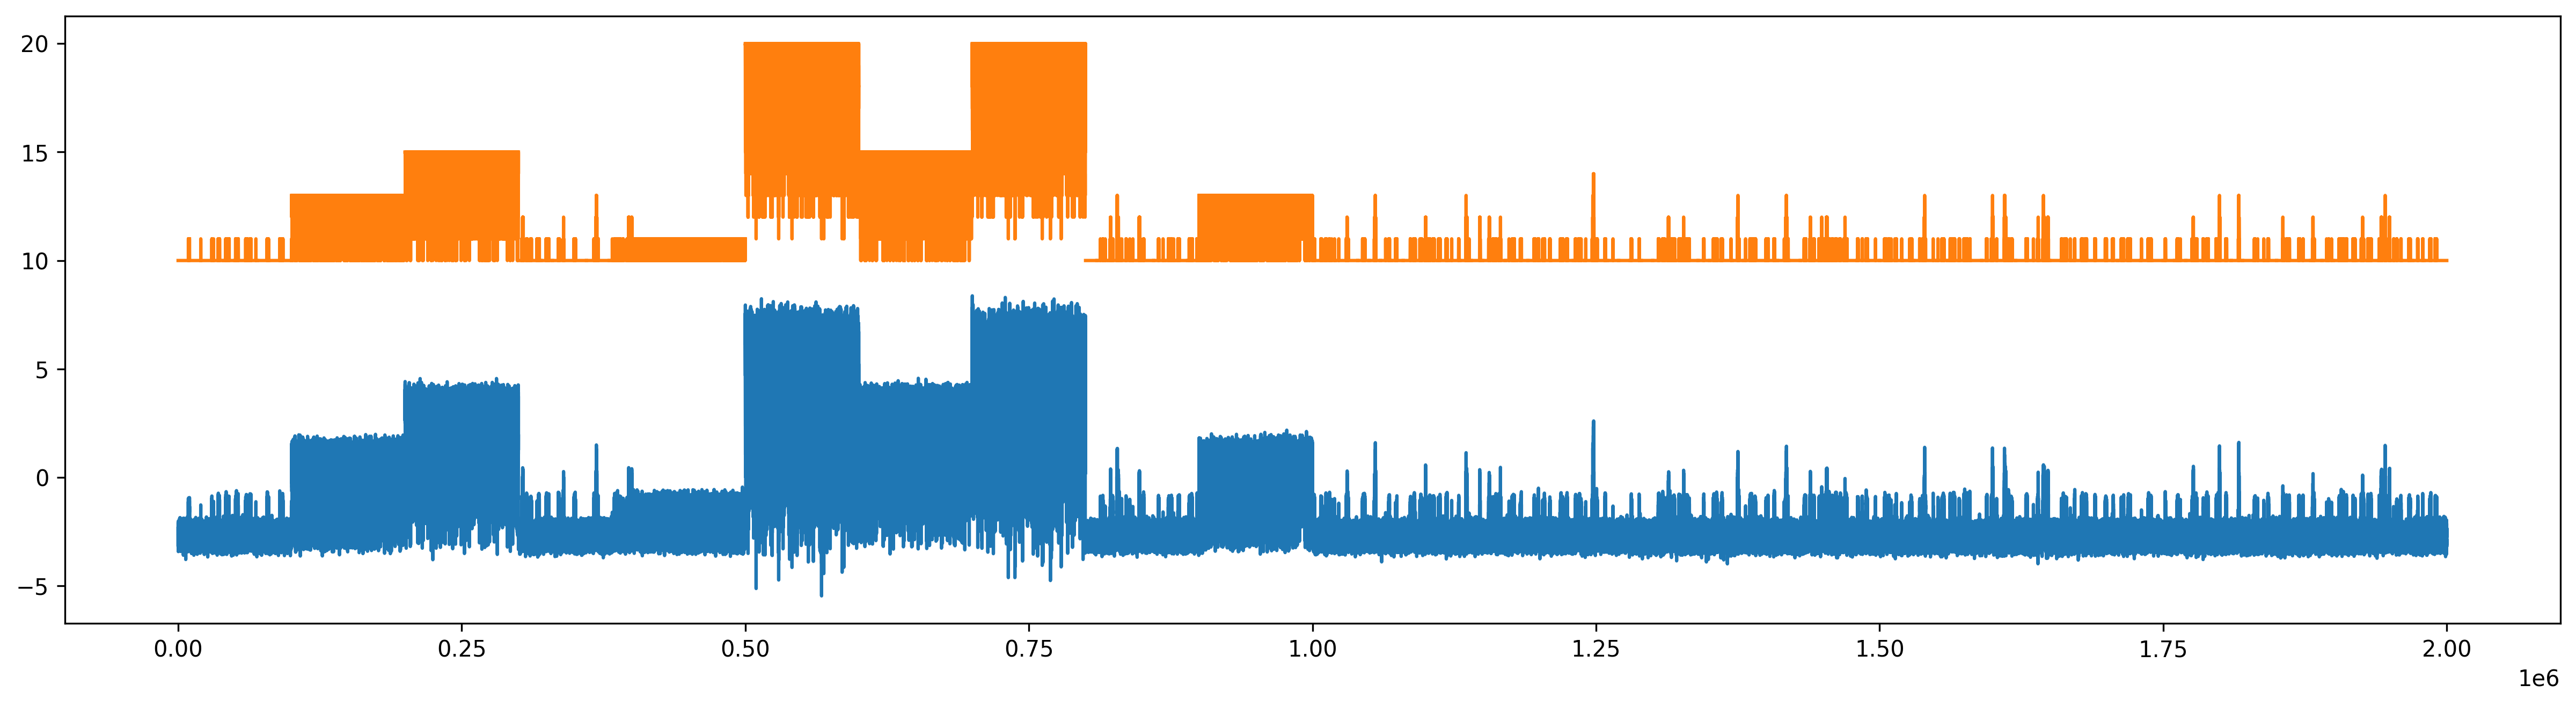

In [57]:
plt.plot(test[0,:].flatten())
plt.plot(open_channels+10)

In [58]:
m_types = [('l',1),('l',2),('l',3),('l',4),('l',5),
           ('h',1),('h',2),('h',3),('h',4),('h',5),('h',10)]
p_dist = np.zeros((len(m_types),11))
for _ in range(100):
    for i,m_type in enumerate(m_types):
        p_dist[i] += np.bincount(sc.get_synth_segment_y(*m_type,SEGMENT_SIZE),minlength=11)/(SEGMENT_SIZE)
p_dist /= 100
ts_densities = np.array(
    [np.bincount(open_channels.view(-1,TEST_SEGMENT_SIZE)[b],minlength=11)/TEST_SEGMENT_SIZE for b in range(20)])

In [59]:
from scipy.spatial import distance
t_types = []
for d in distance.cdist(ts_densities,p_dist): t_types.append(m_types[d.argmin()])
t_types

[('l', 2),
 ('h', 3),
 ('h', 5),
 ('l', 3),
 ('h', 1),
 ('h', 10),
 ('h', 5),
 ('h', 10),
 ('l', 2),
 ('h', 3),
 ('l', 2),
 ('l', 2),
 ('l', 2),
 ('l', 3),
 ('l', 3),
 ('l', 3),
 ('l', 2),
 ('l', 2),
 ('l', 1),
 ('l', 3)]

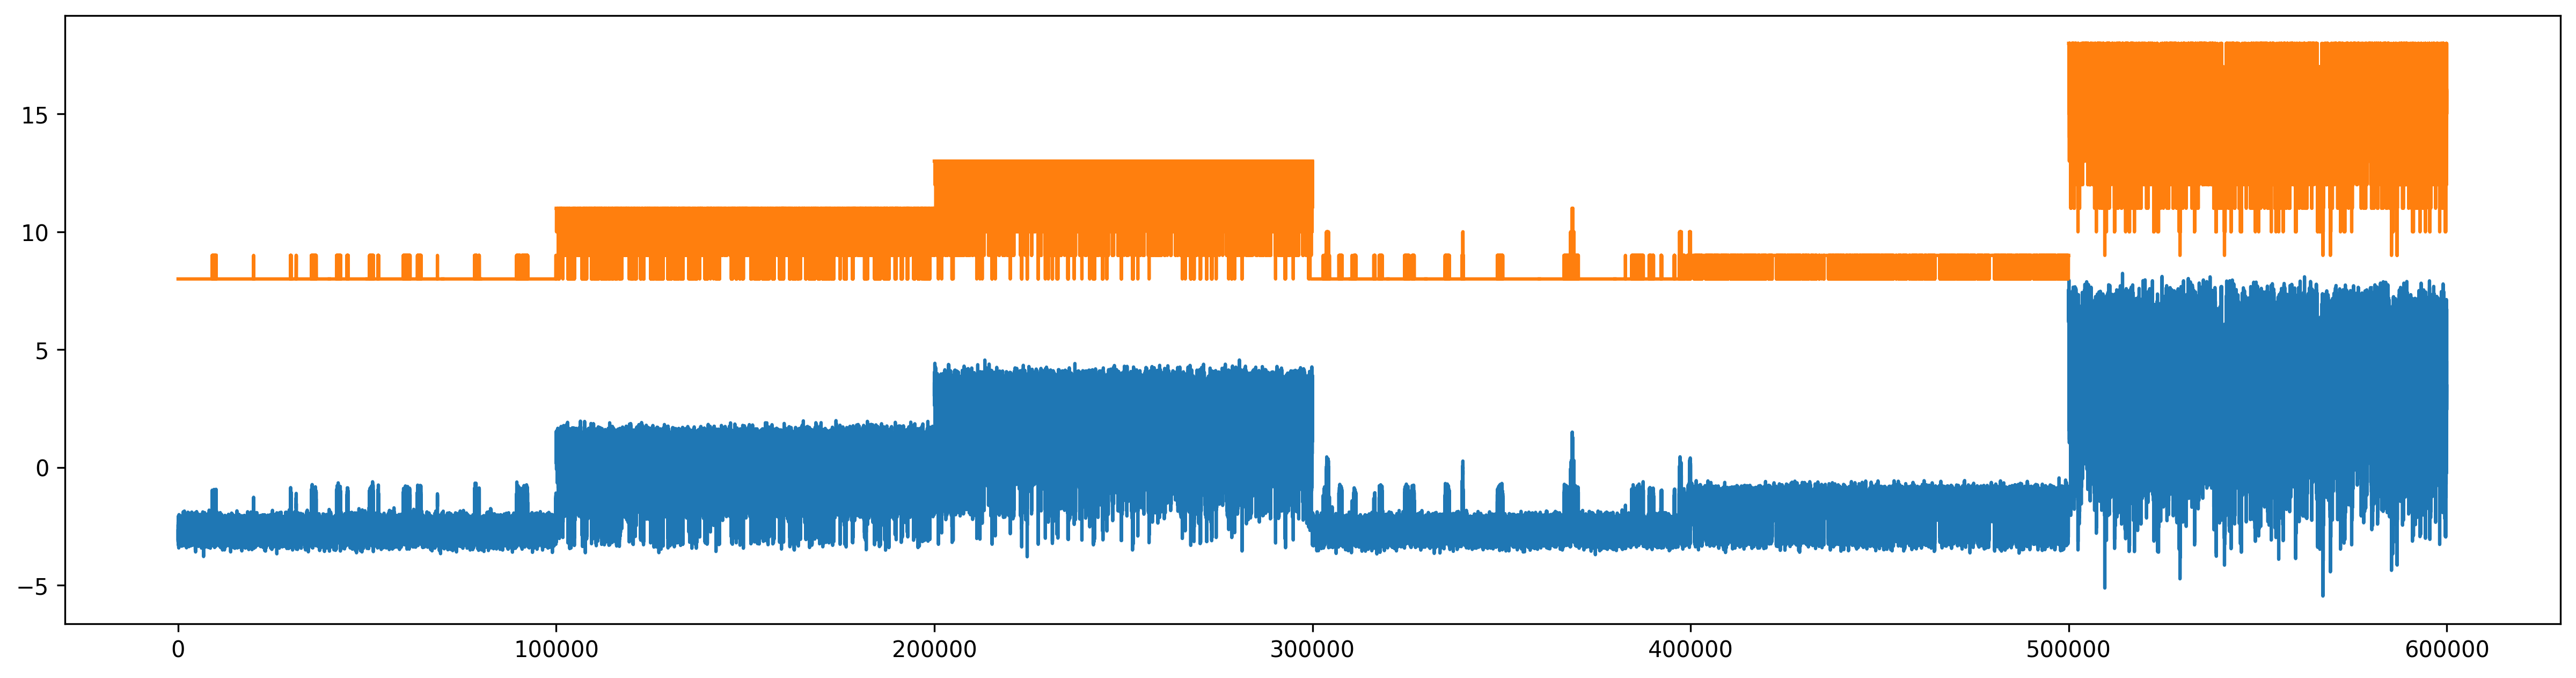

In [60]:
#plt.axvline(100_000, -5, 10, label='pyplot vertical line')
plt.plot(test_x[...,0].flatten()[:600000])
plt.plot(open_channels[:600000]+8)


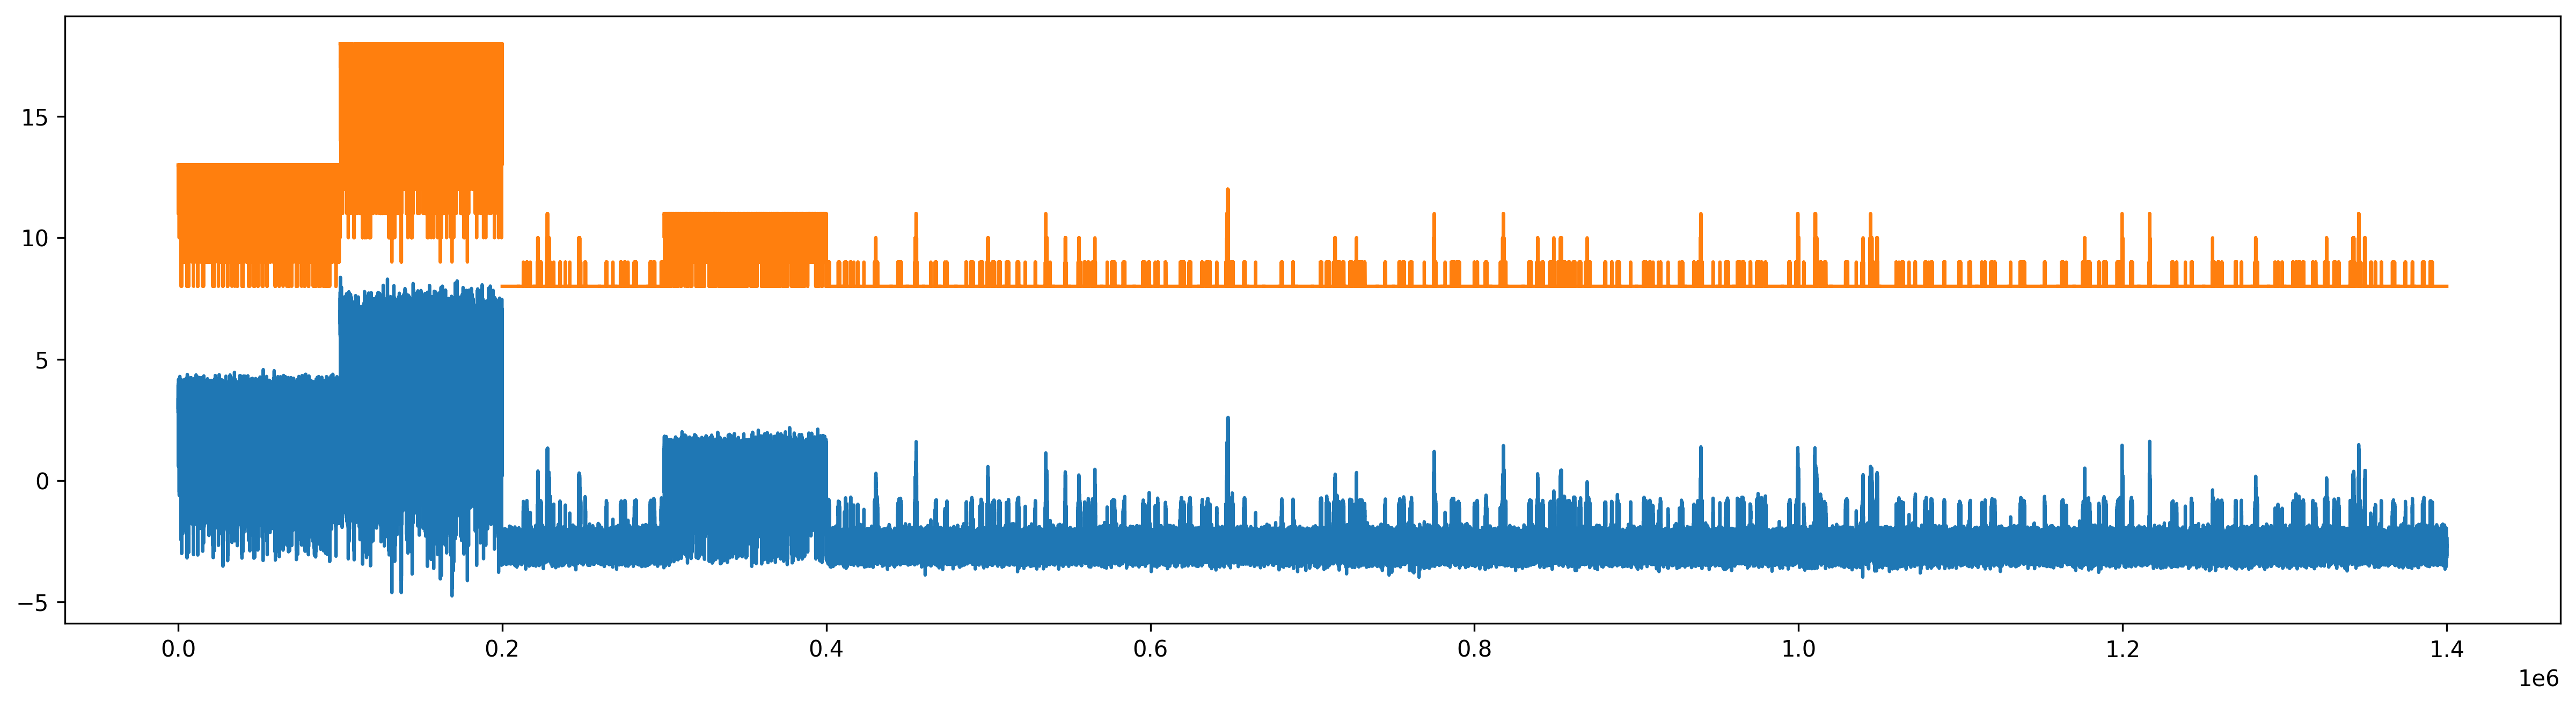

In [61]:
plt.plot(test_x[...,0].flatten()[600000:])
plt.plot(open_channels[600000:]+8)

In [62]:
train_types = [('l', 1),
 ('l', 1),
 ('h', 1),
 ('h', 3),
 ('h', 10),
 ('h', 5),
 ('h', 1),
 ('h', 5),
 ('h', 10)]

torch.Size([500000]) torch.Size([500000])
torch.Size([500000]) torch.Size([500000])
torch.Size([500000]) torch.Size([500000])
torch.Size([500000]) torch.Size([500000])
torch.Size([500000]) torch.Size([500000])
torch.Size([500000]) torch.Size([500000])
torch.Size([500000]) torch.Size([500000])
torch.Size([500000]) torch.Size([500000])
torch.Size([500000]) torch.Size([500000])


defaultdict(list,
            {('l', 1): [0.24515989422798157, 0.24700333178043365],
             ('h', 1): [0.24486009776592255, 0.24472913146018982],
             ('h', 3): [0.265836238861084],
             ('h', 10): [0.4045635759830475, 0.40377897024154663],
             ('h', 5): [0.28642651438713074, 0.28378981351852417]})

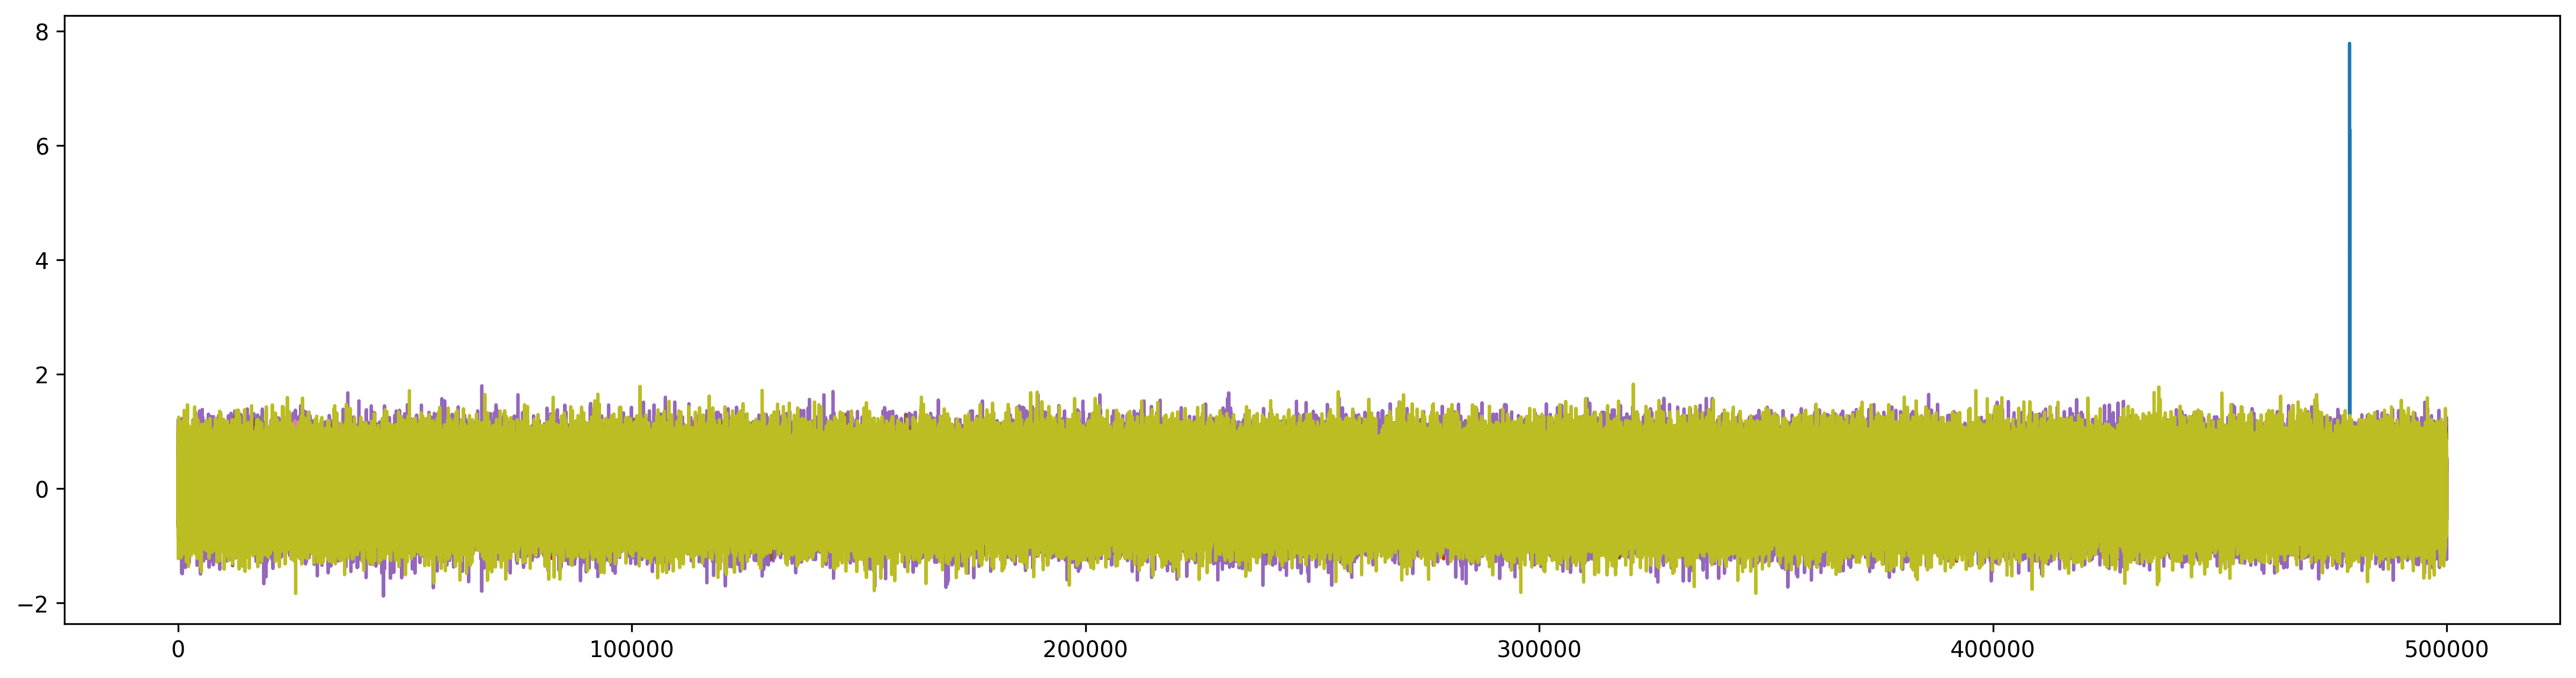

In [63]:
train_types_std = defaultdict(list)
for s,tt in enumerate(train_types):
    xs = train_k_x[s,:].flatten()
    ys = train_k_y[s,:].flatten()
    print(ys.shape,xs.shape)
    x_pred = sc.get_synth_segment_xy(None,None,size=SEGMENT_SIZE,y=ys,add_noise=False)[0].flatten()
    plt.plot(xs-x_pred)
    std = (xs-x_pred).std().item()
    train_types_std[tt].append(std)
    #plt.plot(x_pred)

train_types_std

0.23767045140266418


tensor(18243)

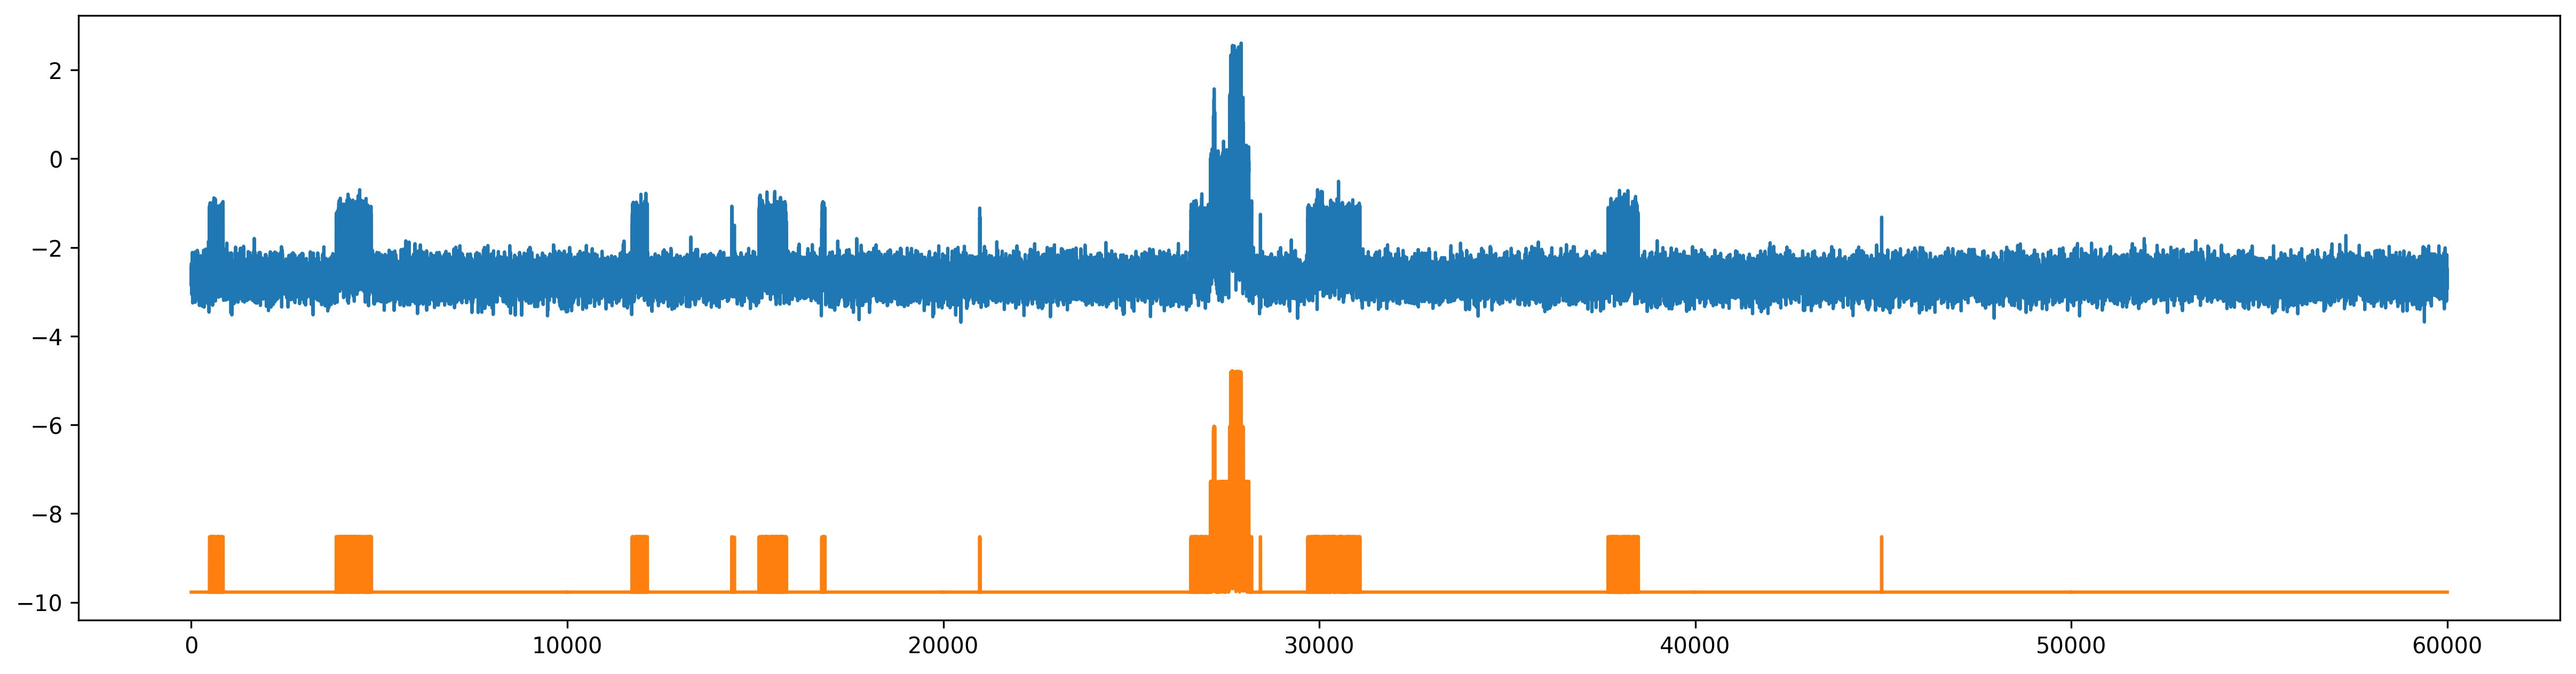

In [64]:
test_types_std = defaultdict(list)
st,sl=20_000,60_000
for s in [12]:
    xs = test_dl.dataset.x[s,:]
    ys = open_channels.view(-1,TEST_SEGMENT_SIZE)[s]
    x_pred = sc.get_synth_segment_xy(None,None,size=TEST_SEGMENT_SIZE,y=ys,add_noise=False)[0]
    residual = xs-x_pred
    l = slice(st,st+sl)
    plt.plot(xs[l])
    plt.plot(x_pred[l]-7)
    #plt.plot(residual[l])
    std = (residual).std().item()
    print(std)
    test_types_std[tt].append((xs-x_pred).std())
    #plt.plot(x_pred)
residual.abs().argmax()

In [65]:
csv_fname = str(p_csv / f'{modelname}_n_tta{n_tta}.csv');csv_fname

'csv/conv_segmt_L1_3430827_5_7_256_8192_t3125000_v12000_BS384_WS1000_pucv0.944114_prcv0.944117_trkcv0.943912_trkscv0.943861_clean_synth_clean50hz_properlb_n_tta1.csv'

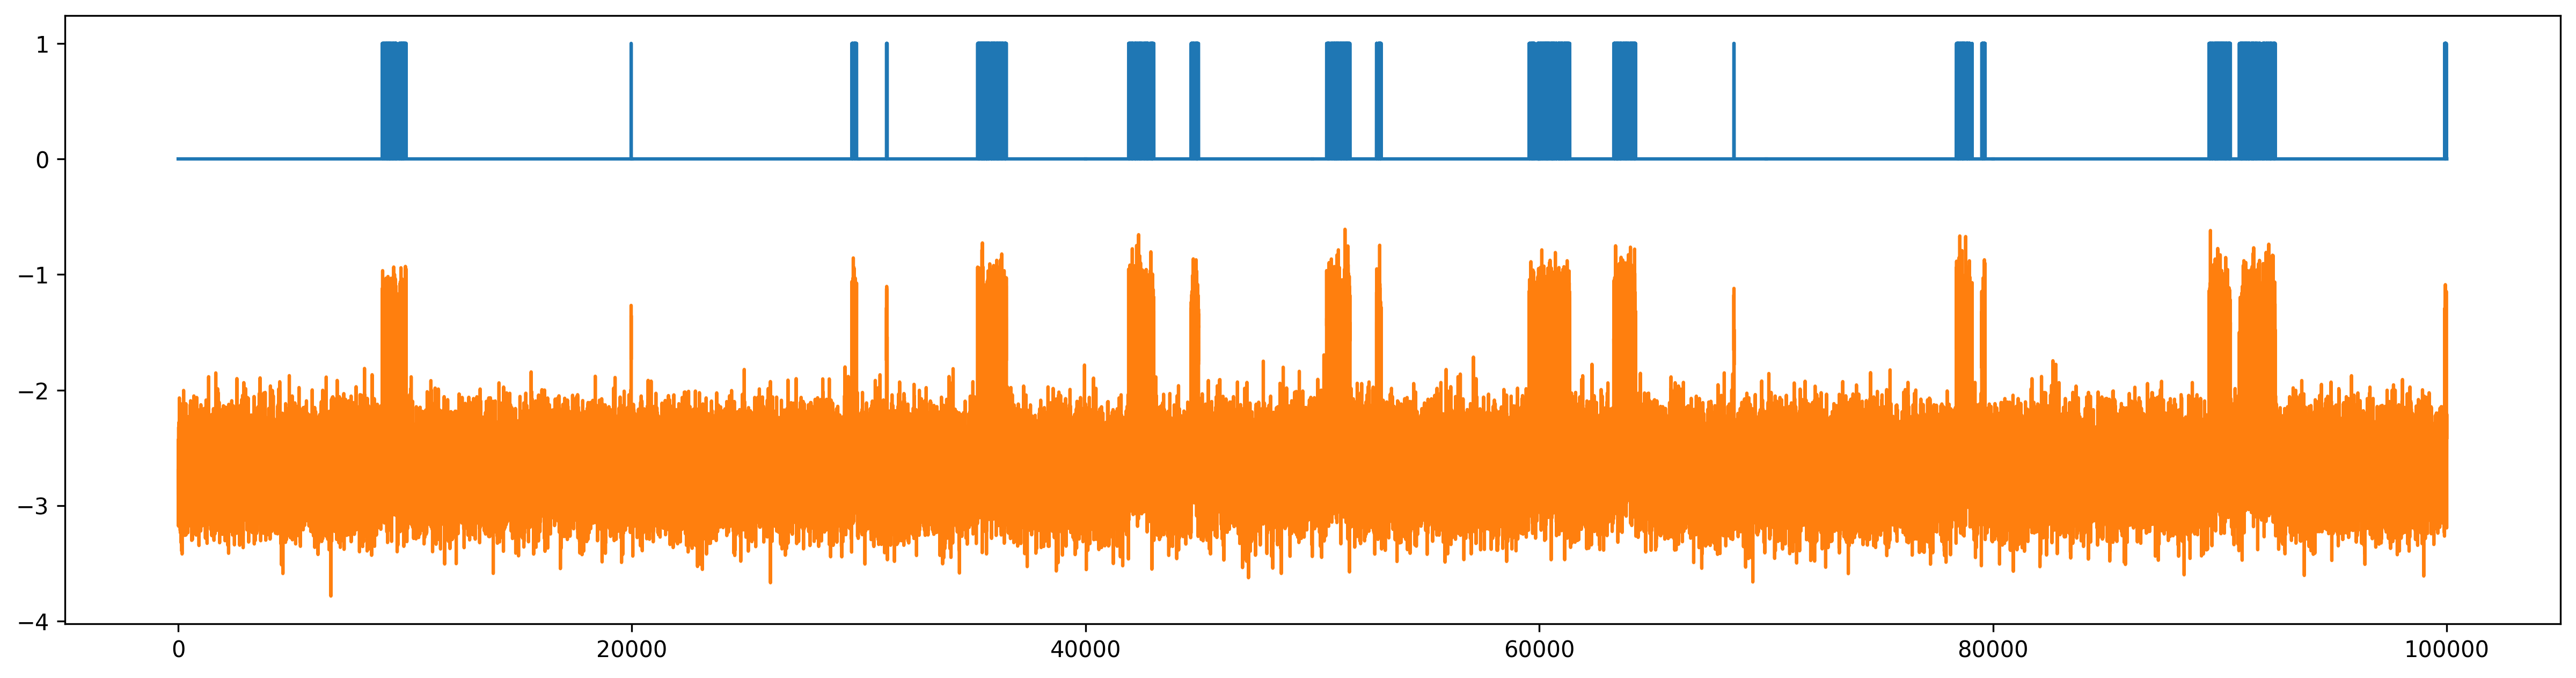

In [66]:
plt.plot(open_channels[:TEST_SEGMENT_SIZE])
plt.plot(test.flatten()[:TEST_SEGMENT_SIZE])

In [67]:
submission_csv_path = p_input / 'sample_submission.csv'
ss = pd.read_csv(submission_csv_path, dtype={'time': str})
test_preds_all = test_preds
test_pred_frame = pd.DataFrame({'time': ss['time'].astype(str), 'open_channels': open_channels})
test_pred_frame.to_csv(csv_fname, index=False)

In [68]:
!kaggle competitions submit -c 'liverpool-ion-switching' -f {csv_fname} -m 'PU {public_cv} PR {private_cv} TRK {train_k_cv} TRKS {train_ks_cv}'

100%|██████████████████████████████████████| 21.0M/21.0M [00:03<00:00, 6.75MB/s]
Successfully submitted to University of Liverpool - Ion Switching

# Prepare L1 datasets

In [ ]:
trainl2_s_x,trainl2_s_y,trainl2_s_fname = gen_cached(train_l2_types,lazy=True)

In [ ]:
trainl2_s_fname

In [ ]:
def get_preds2(dl):
    gc.collect()
    torch.cuda.empty_cache()
    learn.model.eval()
    while isinstance(learn.model,nn.DataParallel): learn.model = learn.model.module
    learn.model = nn.DataParallel(learn.model)
    preds = None #torch.empty(*dl.x.shape).flatten()
    with torch.no_grad():
        i = 0
        for x in progress_bar(dl):
            p, _ = learn.model([xc.cuda() for xc in x[0]])
            p = p.view(-1,p.shape[-1])
            if preds is None: preds = torch.empty(*dl.x.shape[:-1],p.shape[-1]).view(-1,p.shape[-1])
            n =  p.shape[0]
            preds[i:i+n] = p
            i += n
    return preds.view(*dl.x.shape[:-1],p.shape[-1])

In [ ]:
testl2_s_preds = get_preds2(test_dl)
torch.save(testl2_s_preds,f"{trainl2_s_fname}_test_{modelname}")

# No

In [ ]:
trainl2_s_ds = IonDataset(trainl2_s_x,trainl2_s_y, jitter=False)

In [ ]:
trainl2_s_preds = get_preds2(make_dl(trainl2_s_ds,shuffle=False))
torch.save(trainl2_s_preds,f"{trainl2_s_fname}_x_{modelname}")

In [ ]:
testl2_s_preds

In [ ]:
trainl2_k_preds = get_preds2(train_k_dl)
torch.save(trainl2_k_preds,f"{trainl2_s_fname}_k_{modelname}")

In [ ]:
trainl2_ks_preds = get_preds2(train_ks_dl)
torch.save(trainl2_ks_preds,f"{trainl2_s_fname}_ks_{modelname}")

In [ ]:
trainl2_public_s_preds = get_preds2(public_s_dl)
torch.save(trainl2_public_s_preds,f"{trainl2_s_fname}_public_s_{modelname}")

In [ ]:
trainl2_private_s_preds = get_preds2(private_s_dl)
torch.save(trainl2_private_s_preds,f"{trainl2_s_fname}_private_s_{modelname}")